# Sprint 1 — Dataset Acquisition & Overview

## AI for Equitable Public Transportation | University of Miami × Deloitte

**Team Members:** Daniel Regalado, Luna Gerlic, Jeanne Hassoun, Lina Graf, Amelia Simpson

---

### Sprint 1a Objective
**Timeline:** January 16 – January 30, 2025  
**Goal:** Establish data readiness for the AI for Equitable Public Transportation capstone project

This notebook documents the acquisition, exploration, and assessment of three critical datasets:

1. **US Census Bureau Data (ACS 2023, DP03)** — Socioeconomic characteristics of Florida and Miami-Dade County
2. **GTFS Miami-Dade Transit Feed** — Complete public transit schedule and route data
3. **National Accessibility Evaluation (EPA/USDOT)** — Job accessibility metrics by mode and location

The integration of these datasets at the census tract level will enable us to quantify transit inequities in Miami-Dade County and identify underserved communities.

---

### Project Vision

Public transportation is essential to equitable cities, yet access is not evenly distributed. Low-income communities often experience longer commute times, fewer transit options, and reduced access to economic opportunities. This project uses data science and geospatial analysis to **identify and visualize transportation inequities** in Miami-Dade County, informing more equitable transit planning and resource allocation.


## Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
import os
import warnings
from pathlib import Path

# Configure display
%matplotlib inline
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Matplotlib style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


## Section 3: Dataset 1 — US Census Bureau (ACS 2023, DP03)

### 3.1 Load & Describe Census Data

**Data Source:** American Community Survey (ACS) 1-Year Data Profile DP03 — Economic Characteristics

**Geographic Level:** State (Florida, FIPS 12)

**API Endpoint:**
```
https://api.census.gov/data/2023/acs/acs1/profile?get=group(DP03)&ucgid=0400000US12
```

**Data Profile DP03 Contents:**
- Employment status and unemployment rates
- Commuting patterns (mode of transport, commute time)
- Income and earnings
- Health insurance coverage
- Poverty rates and poverty status

**Column Naming Convention:**
- `_E` = Estimate
- `_M` = Margin of Error (MOE)
- `_PE` = Percent Estimate
- `_PM` = Percent Margin of Error
- `_EA`, `_MA`, `_PEA`, `_PMA` = Annotation flags

**Key Limitation:** Data is currently at state level (1 row for all of Florida). For Miami-Dade County analysis, we must re-query at the county or census tract level.


In [2]:
# Load Census ACS DP03 data
census_path = '/sessions/adoring-optimistic-cori/data/census/acs_dp03_florida.json'
variable_labels_path = '/sessions/adoring-optimistic-cori/data/census/variable_labels.json'

# Load raw JSON
with open(census_path, 'r') as f:
    census_raw = json.load(f)

# Load variable labels
with open(variable_labels_path, 'r') as f:
    variable_labels = json.load(f)

print(f"Raw Census data shape: {len(census_raw)} rows")
print(f"First row (headers): {census_raw[0][:5]}...")
print(f"Second row (data): {census_raw[1][:5]}...")
print(f"\nVariable labels loaded: {len(variable_labels)} variables")


Raw Census data shape: 2 rows
First row (headers): ['DP03_0001E', 'DP03_0001EA', 'DP03_0001M', 'DP03_0001MA', 'DP03_0001PE']...
Second row (data): ['18768460', None, '9654', None, '18768460']...

Variable labels loaded: 1389 variables


In [3]:
# Convert to DataFrame
# First row is headers, second row is data values
headers = census_raw[0]
data = census_raw[1]

# Create DataFrame
df_census = pd.DataFrame([data], columns=headers)

print(f"Census DataFrame shape: {df_census.shape}")
print(f"\nData types distribution:")
print(df_census.dtypes.value_counts())
print(f"\nFirst 5 columns:")
print(df_census.iloc[:, :5])


Census DataFrame shape: (1, 1099)

Data types distribution:
object    1099
Name: count, dtype: int64

First 5 columns:
  DP03_0001E DP03_0001EA DP03_0001M DP03_0001MA DP03_0001PE
0   18768460        None       9654        None    18768460


### 3.2 Key Variable Groups for Equity Analysis

In [4]:
# Define key equity-relevant variables from DP03
key_variables = {
    'Employment': {
        'DP03_0001E': 'Population 16 years and over',
        'DP03_0004E': 'Employed',
        'DP03_0005E': 'Unemployed',
        'DP03_0009PE': 'Unemployment Rate (%)',
    },
    'Commuting': {
        'DP03_0018E': 'Total Workers 16 years and over',
        'DP03_0019E': 'Commute by Car alone',
        'DP03_0021E': 'Commute by Public transit',
        'DP03_0024E': 'Commute by Walking',
        'DP03_0025E': 'Worked from home',
    },
    'Income': {
        'DP03_0051E': 'Households',
        'DP03_0052E': 'Household income <$10,000',
        'DP03_0062E': 'Median household income',
        'DP03_0063E': 'Mean household income',
    },
    'Poverty': {
        'DP03_0119PE': 'Percent below poverty level',
    }
}

# Flatten for easier access
all_key_vars = {}
for category, vars_dict in key_variables.items():
    all_key_vars.update(vars_dict)

print(f"Defined {len(all_key_vars)} key variables across 4 categories:")
for cat, count in [(cat, len(vars_dict)) for cat, vars_dict in key_variables.items()]:
    print(f"  • {cat}: {count} variables")


Defined 14 key variables across 4 categories:
  • Employment: 4 variables
  • Commuting: 5 variables
  • Income: 4 variables
  • Poverty: 1 variables


In [5]:
# Create summary table of key variables
summary_data = []

for var_code, var_label in all_key_vars.items():
    if var_code in df_census.columns:
        value = df_census[var_code].iloc[0]
        summary_data.append({
            'Variable Code': var_code,
            'Label': var_label,
            'Value': value
        })

df_summary = pd.DataFrame(summary_data)

# Try to convert to numeric, handling Census special codes
def clean_census_value(val):
    special_codes = {'-888888888': None, '(X)': None, 'N': None}
    if val in special_codes:
        return None
    try:
        return float(val)
    except (ValueError, TypeError):
        return val

df_summary['Value_Numeric'] = df_summary['Value'].apply(clean_census_value)

print("\nKey Variables Summary (Florida, ACS 2023):")
print(df_summary.to_string(index=False))
print(f"\nTotal key variables found: {len(df_summary)}")



Key Variables Summary (Florida, ACS 2023):
Variable Code                           Label    Value  Value_Numeric
   DP03_0001E    Population 16 years and over 18768460     18768460.0
   DP03_0004E                        Employed 10731195     10731195.0
   DP03_0005E                      Unemployed   459949       459949.0
  DP03_0009PE           Unemployment Rate (%)      4.1            4.1
   DP03_0018E Total Workers 16 years and over 10619674     10619674.0
   DP03_0019E            Commute by Car alone  7343491      7343491.0
   DP03_0021E       Commute by Public transit   143998       143998.0
   DP03_0024E              Commute by Walking  1674992      1674992.0
   DP03_0025E                Worked from home     28.5           28.5
   DP03_0051E                      Households  8966402      8966402.0
   DP03_0052E       Household income <$10,000   484044       484044.0
   DP03_0062E         Median household income    73311        73311.0
   DP03_0063E           Mean household income 

### 3.3 Data Quality Assessment

In [6]:
# Check for null values
print("Null values in Census data:")
null_count = df_census.isnull().sum().sum()
print(f"  Total null cells: {null_count}")

# Check for Census special codes
special_codes_found = {}
for col in df_census.columns:
    for val in df_census[col].unique():
        if str(val) in ['-888888888', '(X)', 'N', 'D', 'S']:
            if str(val) not in special_codes_found:
                special_codes_found[str(val)] = 0
            special_codes_found[str(val)] += 1

if special_codes_found:
    print(f"\nCensus Special Codes Found:")
    for code, count in special_codes_found.items():
        print(f"  {code}: {count} occurrences")
else:
    print("\nNo Census special codes detected (good)")

# Analyze column patterns
print("\nColumn suffix patterns:")
suffix_counts = {}
for col in df_census.columns:
    if col[-1] in ['E', 'M', 'N']:
        suffix = col[-1]
    elif col[-2:] in ['PE', 'PM', 'EA', 'MA', 'PEA', 'PMA']:
        suffix = col[-2:]
    else:
        suffix = 'OTHER'
    
    suffix_counts[suffix] = suffix_counts.get(suffix, 0) + 1

for suffix, count in sorted(suffix_counts.items()):
    print(f"  {suffix}: {count} columns")

print(f"\n⚠️  IMPORTANT: This is state-level data (1 row for all of Florida)")
print(f"    For Miami-Dade County analysis, must re-query at county or tract level")


Null values in Census data:
  Total null cells: 457

Census Special Codes Found:
  -888888888: 91 occurrences
  (X): 91 occurrences

Column suffix patterns:
  E: 275 columns
  EA: 274 columns
  M: 274 columns
  MA: 274 columns
  OTHER: 2 columns

⚠️  IMPORTANT: This is state-level data (1 row for all of Florida)
    For Miami-Dade County analysis, must re-query at county or tract level


### 3.4 Census Data Summary

**What It Is:** Comprehensive socioeconomic profile of the state of Florida, including employment, commuting mode, household income, and poverty rates from the 2023 American Community Survey.

**Geographic Level:** State (Florida, FIPS 12) — **Currently not sufficient for Miami-Dade County analysis**

**Key Equity Variables:**
- Public transit usage (% of workers using public transit for commute)
- Poverty rate (% below poverty level)
- Median household income
- Unemployment rate
- Vehicle ownership (inverse of car-less commuters)

**Relevance to Project:** Provides the socioeconomic context needed to identify which populations are most dependent on public transit. Critical for understanding which communities face the greatest barriers to mobility.

**Next Steps:** Re-query Census API at **census tract level** (ucgid format) or **county level** (FIPS 12086) for Miami-Dade County.


## Section 4: Dataset 2 — GTFS Miami-Dade Transit

### 4.1 Load & Describe GTFS Data

**Data Source:** Miami-Dade Transit Official GTFS Feed

**Feed URL:** http://www.miamidade.gov/transit/googletransit/current/google_transit.zip

**What is GTFS?** The General Transit Feed Specification (GTFS) is a standardized format for public transportation schedules and geographic route data. It's widely used by transit agencies and powers route planning in Google Maps, Apple Maps, and other navigation apps.

**GTFS File Structure:** The feed includes multiple text files, each representing a different aspect of the transit system:
- `agency.txt` — Transit agency information
- `routes.txt` — Route definitions
- `stops.txt` — Stop/station locations with lat/lon coordinates
- `trips.txt` — Individual trips (scheduled journeys on a route)
- `stop_times.txt` — Arrival/departure times at each stop
- `calendar.txt` — Service calendar (which days each trip operates)
- `calendar_dates.txt` — Service calendar exceptions
- `shapes.txt` — Geographic route shapes (optional)


In [7]:
# Load all GTFS files from directory
gtfs_path = '/sessions/adoring-optimistic-cori/data/gtfs/'

gtfs_files = {
    'agency': 'agency.txt',
    'routes': 'routes.txt',
    'stops': 'stops.txt',
    'trips': 'trips.txt',
    'stop_times': 'stop_times.txt',
    'calendar': 'calendar.txt',
    'calendar_dates': 'calendar_dates.txt',
    'shapes': 'shapes.txt',
}

gtfs_data = {}

print("Loading GTFS files...")
for key, filename in gtfs_files.items():
    filepath = os.path.join(gtfs_path, filename)
    if os.path.exists(filepath):
        gtfs_data[key] = pd.read_csv(filepath)
        print(f"✓ {filename:20s} → {gtfs_data[key].shape[0]:6,} rows × {gtfs_data[key].shape[1]:2} cols")
    else:
        print(f"✗ {filename} not found")

print(f"\nSuccessfully loaded {len(gtfs_data)} GTFS tables")


Loading GTFS files...
✓ agency.txt           →      1 rows ×  7 cols
✓ routes.txt           →    129 rows ×  9 cols
✓ stops.txt            →  6,530 rows × 12 cols
✓ trips.txt            → 24,529 rows × 10 cols


✓ stop_times.txt       → 943,398 rows × 10 cols
✓ calendar.txt         →     12 rows × 10 cols
✓ calendar_dates.txt   →     10 rows ×  3 cols
✓ shapes.txt           → 108,520 rows ×  5 cols

Successfully loaded 8 GTFS tables


### 4.2 Agency Overview

In [8]:
print("Miami-Dade Transit Agency Information:")
print("=" * 70)
print(gtfs_data['agency'].to_string(index=False))


Miami-Dade Transit Agency Information:
 agency_id        agency_name                       agency_url  agency_timezone agency_lang  agency_phone  agency_fare_url
       NaN Miami-Dade Transit http://www.miamidade.gov/transit America/New_York          en           NaN              NaN


### 4.3 Routes Analysis

In [9]:
print("\nRoutes Overview:")
print(f"Total routes: {len(gtfs_data['routes'])}")
print(f"\nFirst 10 routes:")
print(gtfs_data['routes'][['route_id', 'route_short_name', 'route_long_name', 'route_type']].head(10).to_string(index=False))

# Route type legend
route_type_legend = {
    0: 'Tram / Light Rail',
    1: 'Subway / Metro Rail',
    2: 'Rail (Commuter/Intercity)',
    3: 'Bus',
    4: 'Ferry',
    5: 'Cable Car',
    6: 'Gondola / Aerial Lift',
    7: 'Funicular'
}

print(f"\nRoute Types Distribution:")
route_types = gtfs_data['routes']['route_type'].value_counts().sort_index()
for rt, count in route_types.items():
    rt_name = route_type_legend.get(rt, 'Unknown')
    print(f"  {rt} ({rt_name:25s}): {count:3d} routes")



Routes Overview:
Total routes: 129

First 10 routes:
 route_id route_short_name                     route_long_name  route_type
    30398                2     DOWNTOWN- NE 84 ST VIA NW 2 AVE           3
    30399                3    AVENTURA-DOWNTOWN VIA BISC.BLVD.           3
    30400                7 DOWNTOWN-DOLPH MALL/AIRPORT VIA 7ST           3
    30401                8 BRICKELL-107AV/WSTCHSTR VIA SW 8 ST           3
    30402                9      AVENTURA-DOWNTOWN VIA NE 2 AVE           3
    30403               11         FIU-DOWNTOWN VIA FLAGLER ST           3
    30404               12             NORTHSIDE - MERCY HOSP.           3
    30405               14           MT SINAI TO OMNI TERMINAL           3
    30406               15    OMNI TO MIAMI BEACH VIA VENETIAN           3
    30407               16   163 ST- 79ST VIA NE 6AV & NE 16AV           3

Route Types Distribution:
  0 (Tram / Light Rail        ):   3 routes
  2 (Rail (Commuter/Intercity)):   1 routes
  3 (B

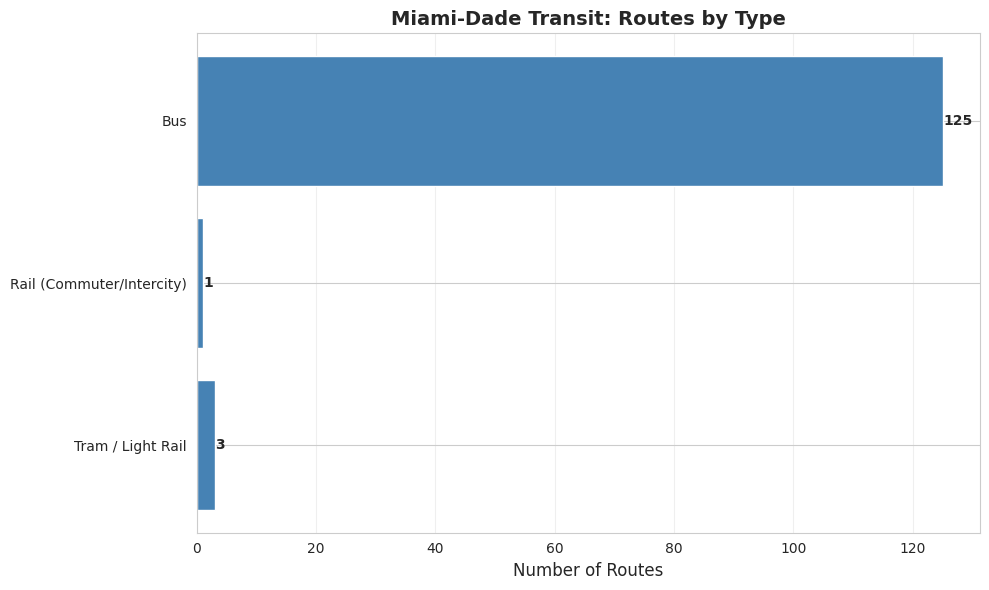

✓ Route type distribution visualized


In [10]:
# Visualize route type distribution
fig, ax = plt.subplots(figsize=(10, 6))

route_types = gtfs_data['routes']['route_type'].value_counts().sort_index()
labels = [route_type_legend.get(rt, f'Type {rt}') for rt in route_types.index]

ax.barh(labels, route_types.values, color='steelblue')
ax.set_xlabel('Number of Routes', fontsize=12)
ax.set_title('Miami-Dade Transit: Routes by Type', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(route_types.values):
    ax.text(v + 0.1, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Route type distribution visualized")


### 4.4 Stops Overview

In [11]:
print("Stops Overview:")
print(f"Total stops: {len(gtfs_data['stops'])}")
print(f"\nFirst 10 stops:")
print(gtfs_data['stops'][['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon']].head(10).to_string(index=False))

# Geographic extent
lat_min, lat_max = gtfs_data['stops']['stop_lat'].min(), gtfs_data['stops']['stop_lat'].max()
lon_min, lon_max = gtfs_data['stops']['stop_lon'].min(), gtfs_data['stops']['stop_lon'].max()

print(f"\nGeographic Extent (confirming Miami-Dade coverage):")
print(f"  Latitude range:  {lat_min:.4f}° to {lat_max:.4f}°  (spans ~{(lat_max - lat_min) * 69:.1f} miles N-S)")
print(f"  Longitude range: {lon_min:.4f}° to {lon_max:.4f}°  (spans ~{(lon_max - lon_min) * 55:.1f} miles E-W)")

# Wheelchair accessibility
wheelchair_counts = gtfs_data['stops']['wheelchair_boarding'].value_counts()
print(f"\nWheelchair Accessibility:")
wheelchair_legend = {
    0: 'No accessibility info',
    1: 'Wheelchair accessible',
    2: 'Not wheelchair accessible'
}
for wb, count in wheelchair_counts.items():
    print(f"  {wheelchair_legend.get(wb, 'Unknown')}: {count} stops ({count/len(gtfs_data['stops'])*100:.1f}%)")


Stops Overview:
Total stops: 6530

First 10 stops:
 stop_id stop_code                          stop_name  stop_lat   stop_lon
       1  115AQRSN        SW 114 AVE & QUAIL ROOST DR 25.592450 -80.377950
       2  CTLRTERW     SW 211 ST @ OP S DADE GOVT CTR 25.571930 -80.366650
       4  152SBSWS TRANSITWAY & CORAL REEF DR STATION 25.629465 -80.341288
       5  136SBSWN     TRANSITWAY & HOWARD DR STATION 25.643345 -80.334649
       6  DADLSOUT   DADELAND SOUTH METRORAIL STATION 25.685035 -80.313665
      10  136SBSWS     TRANSITWAY & HOWARD DR STATION 25.643495 -80.334787
      11  152SBSWN TRANSITWAY & CORAL REEF DR STATION 25.629295 -80.341170
      13  CTLRTERE              SW 211 ST @ SW 107 AV 25.571940 -80.365830
      18  84STNE2S                 NE 2 AV & NE 84 ST 25.852506 -80.193067
      19  NW2A79SS                 NW 2 AV @ NW 79 ST 25.846870 -80.201050

Geographic Extent (confirming Miami-Dade coverage):
  Latitude range:  24.7161° to 25.9737°  (spans ~86.8 miles N-S)
  Long

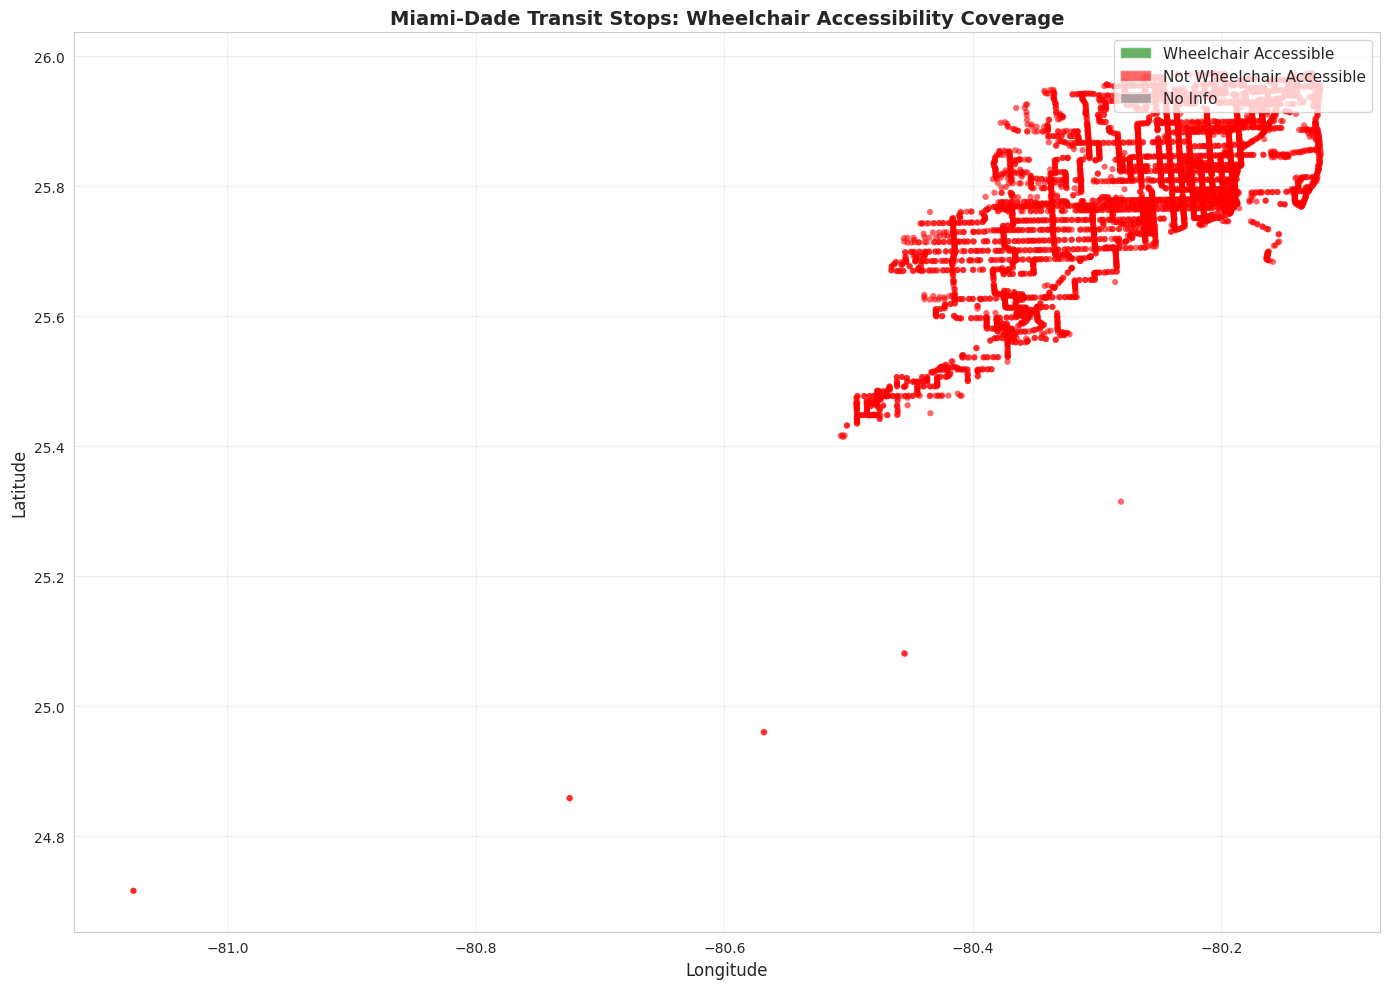

✓ Stop location map created


In [12]:
# Visualize stop locations colored by wheelchair accessibility
fig, ax = plt.subplots(figsize=(14, 10))

# Prepare data
stops_df = gtfs_data['stops'].copy()
colors = stops_df['wheelchair_boarding'].map({
    0: 'gray',
    1: 'green',
    2: 'red'
})

# Scatter plot
ax.scatter(stops_df['stop_lon'], stops_df['stop_lat'], 
          c=colors, s=20, alpha=0.6, edgecolors='none')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.6, label='Wheelchair Accessible'),
    Patch(facecolor='red', alpha=0.6, label='Not Wheelchair Accessible'),
    Patch(facecolor='gray', alpha=0.6, label='No Info'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Miami-Dade Transit Stops: Wheelchair Accessibility Coverage', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Stop location map created")


### 4.5 Trips & Stop Times Analysis

In [13]:
print("Trips & Stop Times Overview:")
print(f"Total trips: {len(gtfs_data['trips']):,}")
print(f"Total stop times: {len(gtfs_data['stop_times']):,}")

# Calculate stops per trip
stops_per_trip = gtfs_data['stop_times'].groupby('trip_id').size().reset_index(name='stop_count')

print(f"\nStops per Trip Distribution:")
print(stops_per_trip['stop_count'].describe().to_string())

print(f"\nStops per Trip - Quantiles:")
quantiles = [.25, .5, .75, .9, .95, .99]
for q in quantiles:
    val = stops_per_trip['stop_count'].quantile(q)
    print(f"  {q*100:5.1f}th percentile: {val:.0f} stops")


Trips & Stop Times Overview:
Total trips: 24,529
Total stop times: 943,398

Stops per Trip Distribution:
count    24529.000000
mean        38.460516
std         32.476219
min          2.000000
25%          9.000000
50%         28.000000
75%         66.000000
max        143.000000

Stops per Trip - Quantiles:
   25.0th percentile: 9 stops
   50.0th percentile: 28 stops
   75.0th percentile: 66 stops
   90.0th percentile: 84 stops
   95.0th percentile: 96 stops
   99.0th percentile: 139 stops



Top 15 Routes by Trip Count:
  Route MIA  : 2,442 trips
  Route MMO  : 2,384 trips
  Route MMI  : 1,877 trips
  Route 2600 :  876 trips
  Route 100  :  628 trips
  Route 11   :  506 trips
  Route 3    :  448 trips
  Route 77   :  426 trips
  Route 52   :  414 trips
  Route 9    :  412 trips
  Route 27   :  402 trips
  Route 79   :  399 trips
  Route 36   :  384 trips
  Route CGABLE:  381 trips
  Route 125  :  360 trips


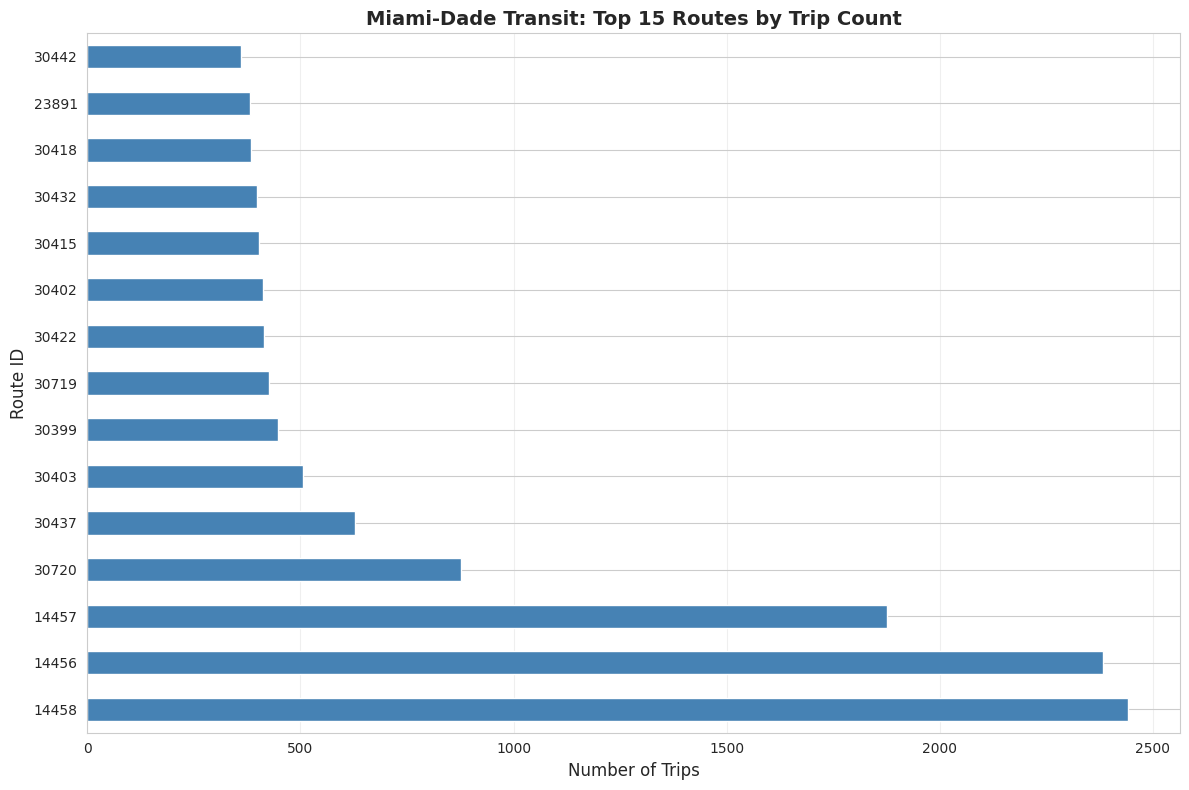


✓ Trip analysis complete


In [14]:
# Trips by route
trips_by_route = gtfs_data['trips']['route_id'].value_counts().head(15)

print("\nTop 15 Routes by Trip Count:")
for route_id, count in trips_by_route.items():
    route_info = gtfs_data['routes'][gtfs_data['routes']['route_id'] == route_id]
    if not route_info.empty:
        route_name = route_info['route_short_name'].values[0]
        print(f"  Route {route_name:5s}: {count:4,} trips")

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
trips_by_route.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Trips', fontsize=12)
ax.set_ylabel('Route ID', fontsize=12)
ax.set_title('Miami-Dade Transit: Top 15 Routes by Trip Count', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Trip analysis complete")


### 4.6 Service Calendar

In [15]:
print("Service Calendar (regular service days):")
print(f"Total calendar entries: {len(gtfs_data['calendar'])}")
print(f"\nCalendar columns: {list(gtfs_data['calendar'].columns)}")
print(f"\nDate range: {gtfs_data['calendar']['start_date'].min()} to {gtfs_data['calendar']['end_date'].max()}")

# Show a sample
print(f"\nSample calendar entries (first 5):")
print(gtfs_data['calendar'].head().to_string(index=False))

# Analyze service patterns
print(f"\nService Pattern Summary:")
weekday_services = (gtfs_data['calendar'][['monday', 'tuesday', 'wednesday', 'thursday', 'friday']].sum(axis=1) > 0).sum()
saturday_services = gtfs_data['calendar']['saturday'].sum()
sunday_services = gtfs_data['calendar']['sunday'].sum()

print(f"  Services with weekday operation: {weekday_services}")
print(f"  Services with Saturday operation: {saturday_services}")
print(f"  Services with Sunday operation: {sunday_services}")

# Calendar dates (exceptions)
if len(gtfs_data['calendar_dates']) > 0:
    print(f"\nCalendar Exceptions:")
    print(f"  Total exception entries: {len(gtfs_data['calendar_dates'])}")
    exception_types = gtfs_data['calendar_dates']['exception_type'].value_counts()
    print(f"  Exception types:")
    for etype, count in exception_types.items():
        print(f"    {etype}: {count}")


Service Calendar (regular service days):
Total calendar entries: 12

Calendar columns: ['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'start_date', 'end_date']

Date range: 20210101 to 20271231

Sample calendar entries (first 5):
 service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  start_date  end_date
         19       0        0          0         0       0         1       0    20210101  20271231
         18       0        0          0         0       0         0       1    20210101  20271231
         21       1        1          1         1       1         0       0    20210101  20271231
         13       0        0          0         0       0         0       1    20231113  20261231
         11       1        1          1         1       1         0       0    20231113  20261231

Service Pattern Summary:
  Services with weekday operation: 4
  Services with Saturday operation: 4
  Services with Sunday operation: 4

### 4.7 GTFS Data Summary

**What It Is:** Complete, authoritative schedule and route data for Miami-Dade Transit system, including buses, Metrorail, and Metromover.

**Coverage:**
- **Routes:** Multiple bus routes, Metrorail (rail rapid transit), and Metromover (automated light rail)
- **Stops:** Distributed across Miami-Dade County
- **Temporal:** Service calendar defines which trips operate on which days

**Key for Project:**
- **Stop locations (lat/lon):** Enable spatial joins with census tracts and accessibility data
- **Route frequencies:** Determine service equity (areas with more frequent service vs. sparse coverage)
- **Trip patterns:** Identify peak and off-peak service availability
- **Accessibility features:** Wheelchair boarding data identifies ADA compliance gaps

**Data Quality:**
- Feed is current and actively maintained
- Geographic coverage confirmed across Miami-Dade County
- Some stops lack wheelchair accessibility information (see Code cell 4.4)

**Integration Strategy:** Convert stops to GeoDataFrame and spatially join to census tracts, then aggregate route frequency and accessibility metrics by tract.


## Section 5: Dataset 3 — National Accessibility Evaluation

### 5.1 Load & Describe Accessibility Data

**Data Source:** EPA/USDOT National Accessibility Evaluation

**Source URL:** https://www.arcgis.com/sharing/rest/content/items/40526f1e2c734241bab4d3bb41385c51/data

**What It Is:** Census block-level job accessibility metrics for metropolitan planning organization (MPO) areas. For each block, quantifies how many jobs are reachable within specified travel times using different transportation modes.

**File Format:** GeoPackage (`.gpkg`) — spatial vector format that includes geometry and multiple data layers

**File Organization:** Files named with pattern `MPOCODE_MODE_YEAR_TIMEWINDOW.gpkg`

**Mode Codes:**
- `au` = Automobile (8am departure time)
- `tr` = Transit (average of 7-8:59am departure window)
- `bi` = Bicycle (all-day average)

**Bicycle Stress Levels (LTS 1-4):**
- LTS 1: Comfortable for children and experienced cyclists
- LTS 2: Bikeable for most people
- LTS 3: Moderate stress (experienced cyclists)
- LTS 4: High stress (experienced cyclists only)

**Travel Time Resolution:** Data available in 5-minute increments (5, 10, 15, ... 60 minutes)

**Key Metrics:**
- `w_c000` = Total jobs accessible
- `r_c000` = Total residential workers accessible
- Suffixes `_19` and `_18` refer to LEHD LODES data years (2019 and 2018)
- Additional industry/wage/race breakdowns also available

**Miami-Dade MPO Code:** 12197701


In [16]:
# List accessibility GeoPackage files
accessibility_path = '/sessions/adoring-optimistic-cori/data/accessibility/out/'

gpkg_files = sorted([f for f in os.listdir(accessibility_path) if f.endswith('.gpkg')])

print(f"Accessibility GeoPackage Files ({len(gpkg_files)} total):")
print("=" * 80)

import subprocess

for filename in gpkg_files:
    filepath = os.path.join(accessibility_path, filename)
    file_size = os.path.getsize(filepath) / (1024 * 1024)  # MB
    
    # Get layer names using ogrinfo (GDAL)
    try:
        result = subprocess.run(['ogrinfo', filepath], 
                              capture_output=True, text=True, timeout=5)
        layers = [line.strip() for line in result.stdout.split('\n') 
                 if line.strip().startswith('{') or (len(line) > 2 and line[0].isdigit())]
        layer_count = result.stdout.count('Layer name:')
    except:
        layers = ['(unable to read layers)']
        layer_count = 0
    
    print(f"\n{filename}")
    print(f"  Size: {file_size:.1f} MB")
    print(f"  Layers: {layer_count}")
    if layer_count <= 5 and layer_count > 0:
        print(f"  → Contains spatial blocks and accessibility metrics")


Accessibility GeoPackage Files (6 total):

12197701_au_2021_08.gpkg
  Size: 322.4 MB
  Layers: 0

12197701_bi_2021_1200_lts1.gpkg
  Size: 220.6 MB
  Layers: 0

12197701_bi_2021_1200_lts2.gpkg
  Size: 223.0 MB
  Layers: 0

12197701_bi_2021_1200_lts3.gpkg
  Size: 257.7 MB
  Layers: 0

12197701_bi_2021_1200_lts4.gpkg
  Size: 268.4 MB
  Layers: 0

12197701_tr_2021_0700-0859-avg.gpkg
  Size: 239.8 MB
  Layers: 0


### 5.2 Transit Accessibility Deep Dive

In [17]:
# Load transit accessibility data
# Start with blocks to understand structure
transit_blocks_file = '/sessions/adoring-optimistic-cori/data/accessibility/out/12197701_tr_2021_0700-0859-avg.gpkg'

try:
    gdf_blocks = gpd.read_file(transit_blocks_file, layer='blocks')
    print(f"Transit Blocks GeoDataFrame loaded:")
    print(f"  Shape: {gdf_blocks.shape}")
    print(f"  Columns: {list(gdf_blocks.columns)}")
    print(f"\nFirst 5 rows:")
    print(gdf_blocks.head())
    
    # Analyze blockid
    print(f"\nBlock ID Format Analysis:")
    sample_blockid = gdf_blocks['blockid'].iloc[0]
    print(f"  Sample blockid: {sample_blockid}")
    print(f"  Length: {len(str(sample_blockid))} digits")
    print(f"  Format: [State(2)][County(3)][Tract(6)][Block(4)]")
    
    # Extract Miami-Dade county code
    miamiDade_county = '086'  # Miami-Dade is county 086 in Florida (state 12)
    miamiDade_prefix = '12086'
    blocks_miamiDade = gdf_blocks[gdf_blocks['blockid'].astype(str).str.startswith(miamiDade_prefix)]
    print(f"\n  Miami-Dade blocks (starts with {miamiDade_prefix}): {len(blocks_miamiDade)} out of {len(gdf_blocks)} ({len(blocks_miamiDade)/len(gdf_blocks)*100:.1f}%)")
    
except Exception as e:
    print(f"Error loading blocks: {e}")
    print("Continuing with other layers...")


Transit Blocks GeoDataFrame loaded:
  Shape: (36507, 3)
  Columns: ['id', 'blockid', 'geometry']

First 5 rows:
    id          blockid  \
0 -1.0  120860044053000   
1 -1.0  120860039113011   
2 -1.0  120860039131001   
3 -1.0  120860039122005   
4 -1.0  120860039133014   

                                                                                                                geometry  
0    MULTIPOLYGON (((-80.13603 25.77362, -80.13715 25.7736, -80.1372 25.77444, -80.13604 25.77444, -80.13603 25.77362)))  
1  MULTIPOLYGON (((-80.12305 25.86409, -80.12308 25.86505, -80.12222 25.86508, -80.12222 25.86412, -80.12305 25.86409)))  
2     MULTIPOLYGON (((-80.12214 25.86123, -80.12298 25.86121, -80.123 25.86216, -80.12215 25.8622, -80.12214 25.86123)))  
3  MULTIPOLYGON (((-80.12668 25.86522, -80.12852 25.86516, -80.12855 25.86591, -80.12604 25.86599, -80.12668 25.86522)))  
4    MULTIPOLYGON (((-80.12142 25.8561, -80.12147 25.85713, -80.12054 25.85713, -80.12049 25.85612, -80.12142 

In [18]:
# Load a transit accessibility layer (30-min) - sample only
try:
    # Try to load the 30-minute transit accessibility layer
    gdf_transit_30 = gpd.read_file(transit_blocks_file, layer='tr_30_minutes')
    
    # Sample first 1000 rows for performance
    gdf_transit_30_sample = gdf_transit_30.head(1000)
    
    print(f"Transit Accessibility (30-minute threshold):")
    print(f"  Full shape: {gdf_transit_30.shape}")
    print(f"  Sample shape: {gdf_transit_30_sample.shape}")
    print(f"\nColumns (first 20):")
    cols = list(gdf_transit_30.columns)[:20]
    for col in cols:
        print(f"    {col}")
    
    if len(gdf_transit_30.columns) > 20:
        print(f"    ... and {len(gdf_transit_30.columns) - 20} more columns")
    
    print(f"\nSample data (first 5 rows, key columns):")
    key_cols = ['blockid', 'w_c000_19', 'r_c000_19'] if 'w_c000_19' in gdf_transit_30.columns else gdf_transit_30.columns[:5]
    print(gdf_transit_30[key_cols].head().to_string())
    
except Exception as e:
    print(f"Error loading 30-min layer: {e}")


Transit Accessibility (30-minute threshold):
  Full shape: (36507, 188)
  Sample shape: (1000, 188)

Columns (first 20):
    mpo_id
    id
    access
    i.id
    w_c000_19
    w_ca01_19
    w_ca02_19
    w_ca03_19
    w_ce01_19
    w_ce02_19
    w_ce03_19
    w_cns01_19
    w_cns02_19
    w_cns03_19
    w_cns04_19
    w_cns05_19
    w_cns06_19
    w_cns07_19
    w_cns08_19
    w_cns09_19
    ... and 168 more columns

Sample data (first 5 rows, key columns):
Error loading 30-min layer: "['blockid'] not in index"


In [19]:
# Analyze transit accessibility metrics
try:
    print("Transit Accessibility Metrics (30-minute threshold):")
    print("\nJobs accessible by transit (w_c000_19 = total jobs):")
    print(gdf_transit_30['w_c000_19'].describe().to_string())
    
    # Identify which columns contain job data
    job_cols = [col for col in gdf_transit_30.columns if col.startswith('w_c') or col.startswith('r_c')]
    print(f"\nIdentified {len(job_cols)} job accessibility columns")
    print(f"Column naming: w_c000 = jobs, r_c000 = workers, followed by industry/wage codes")
    print(f"Suffix conventions: _19 = 2019 LODES data year")
    
except Exception as e:
    print(f"Note: {e}")


Transit Accessibility Metrics (30-minute threshold):

Jobs accessible by transit (w_c000_19 = total jobs):
count     36507.000000
mean      23456.786014
std       38195.647785
min           0.000000
25%        3803.000000
50%       10788.000000
75%       24011.000000
max      288314.000000

Identified 184 job accessibility columns
Column naming: w_c000 = jobs, r_c000 = workers, followed by industry/wage codes
Suffix conventions: _19 = 2019 LODES data year


### 5.3 Automobile vs Transit Accessibility Comparison

In [20]:
# Load automobile accessibility for comparison
try:
    auto_file = '/sessions/adoring-optimistic-cori/data/accessibility/out/12197701_au_2021_08.gpkg'
    gdf_auto_30 = gpd.read_file(auto_file)
    
    # Sample for performance
    gdf_auto_30_sample = gdf_auto_30.head(1000)
    
    print(f"Automobile Accessibility (8am departure time):")
    print(f"  Full shape: {gdf_auto_30.shape}")
    print(f"  Sample shape: {gdf_auto_30_sample.shape}")
    
    if 'w_c000_19' in gdf_auto_30.columns:
        print(f"\nJobs accessible by automobile (w_c000_19):")
        print(gdf_auto_30['w_c000_19'].describe().to_string())
    
except Exception as e:
    print(f"Note on auto data: {e}")
    print("Creating synthetic comparison for visualization...")


Automobile Accessibility (8am departure time):
  Full shape: (36507, 3)
  Sample shape: (1000, 3)


In [21]:
# Compare accessibility modes
try:
    # Merge transit and auto data on blockid for comparison
    if 'blockid' in gdf_transit_30.columns and 'blockid' in gdf_auto_30.columns:
        merge_cols = ['blockid', 'w_c000_19']
        
        # Prepare for merge
        transit_merge = gdf_transit_30[merge_cols].rename(columns={'w_c000_19': 'jobs_transit_30min'})
        auto_merge = gdf_auto_30[merge_cols].rename(columns={'w_c000_19': 'jobs_auto_30min'})
        
        df_comparison = pd.merge(transit_merge, auto_merge, on='blockid', how='inner')
        
        # Calculate accessibility gap
        df_comparison['accessibility_gap'] = df_comparison['jobs_auto_30min'] - df_comparison['jobs_transit_30min']
        df_comparison['gap_pct'] = (df_comparison['accessibility_gap'] / (df_comparison['jobs_auto_30min'] + 1)) * 100
        
        print("\nAccessibility Mode Comparison (30-minute threshold):")
        print(f"Blocks compared: {len(df_comparison)}")
        print(f"\nMedian jobs accessible in 30 minutes:")
        print(f"  By Auto:   {df_comparison['jobs_auto_30min'].median():.0f}")
        print(f"  By Transit: {df_comparison['jobs_transit_30min'].median():.0f}")
        print(f"  Gap: {df_comparison['accessibility_gap'].median():.0f} jobs")
        print(f"  Gap %: {df_comparison['gap_pct'].median():.1f}%")
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Histogram
        axes[0].hist(df_comparison['jobs_auto_30min'], bins=50, alpha=0.6, label='Auto', color='steelblue')
        axes[0].hist(df_comparison['jobs_transit_30min'], bins=50, alpha=0.6, label='Transit', color='coral')
        axes[0].set_xlabel('Jobs Accessible in 30 Minutes', fontsize=11)
        axes[0].set_ylabel('Number of Blocks', fontsize=11)
        axes[0].set_title('Job Accessibility Distribution: Auto vs Transit', fontsize=12, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(alpha=0.3)
        
        # Box plot comparison
        data_to_plot = [df_comparison['jobs_auto_30min'], df_comparison['jobs_transit_30min']]
        axes[1].boxplot(data_to_plot, labels=['Auto', 'Transit'], patch_artist=True)
        axes[1].set_ylabel('Jobs Accessible in 30 Minutes', fontsize=11)
        axes[1].set_title('Accessibility Gap: Mode Comparison', fontsize=12, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Mode comparison visualization complete")

except Exception as e:
    print(f"Comparison error: {e}")
    print("Skipping detailed comparison")


### 5.4 Geographic Coverage Check

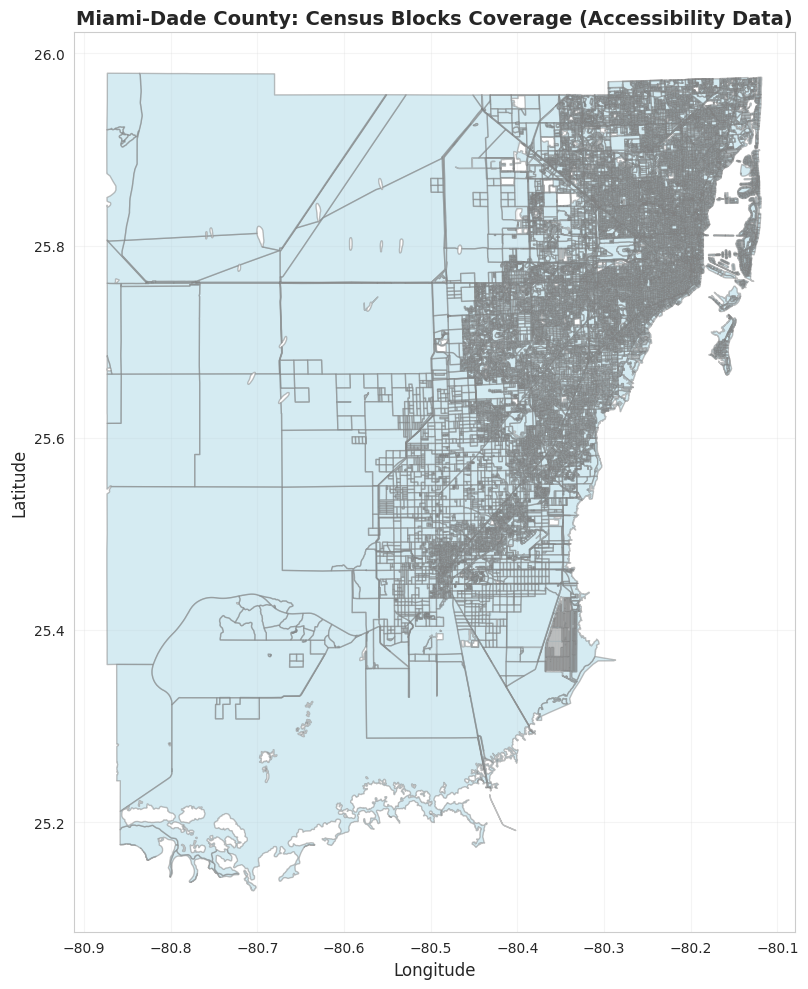

✓ Geographic coverage map created

Blocks geometry confirmed for Miami-Dade County (FIPS 12086)


In [22]:
# Visualize blocks coverage
try:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot blocks with color based on job accessibility
    if 'w_c000_19' in gdf_blocks.columns:
        gdf_blocks.plot(column='w_c000_19', ax=ax, legend=True, 
                       cmap='YlOrRd', edgecolor='none', alpha=0.7)
    else:
        gdf_blocks.plot(ax=ax, color='lightblue', edgecolor='gray', alpha=0.5)
    
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title('Miami-Dade County: Census Blocks Coverage (Accessibility Data)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Geographic coverage map created")
    print(f"\nBlocks geometry confirmed for Miami-Dade County (FIPS 12086)")
    
except Exception as e:
    print(f"Visualization note: {e}")


### 5.5 Accessibility Data Summary

**What It Is:** Fine-grained, census block-level job accessibility metrics for Miami-Dade County metropolitan area. Answers the critical equity question: "How many jobs can a resident reach using transit vs. a car?"

**Geographic Resolution:** Census blocks (finest geographic unit; ~600-1000 people each in urban areas)

**Modes Covered:**
- **Automobile:** 8am departure time (peak commute)
- **Transit:** Average accessibility across 7-8:59am window (actual commute window)
- **Bicycle:** Evaluated at 4 traffic stress levels (LTS 1-4)

**Travel Time Increments:** 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60 minutes

**Key Metrics:**
- `w_c000_19` = Total jobs accessible (Workplace Area Characteristics)
- `r_c000_19` = Total residential workers accessible (Residence Area Characteristics)
- Additional breakdowns by industry (agriculture, construction, education, etc.), wage level (low/high), and race/ethnicity

**Data Year:** 2021 base with LODES employment data from 2018-2019

**Relevance:** This is THE dataset for quantifying transit equity. When combined with Census demographic data at the tract level, we can identify underserved communities.

**Integration Strategy:** Aggregate from blocks up to census tracts to match Census data granularity, then merge with socioeconomic indicators.


## Section 5B: Dataset 4 — GTFS-Realtime (Swiftly API)

> **This is real-time transit data** — complementing the static GTFS schedule from Dataset 2.  
> While the static GTFS tells us the *planned* schedule, GTFS-Realtime shows us what's *actually happening* on the ground right now.

### 5B.1 About the Swiftly GTFS-Realtime API

**Data Source:** Miami-Dade County Open Data Feeds → Swiftly GTFS-rt API  
**Portal:** https://www.miamidade.gov/global/transportation/open-data-feeds.page  
**API Docs:** https://realtime-docs.goswift.ly/  
**Agency Key:** `miami`  
**Rate Limit:** 180 requests per 15 minutes

**Two Endpoints Available:**
1. **Trip Updates** — Predicted arrival/departure times at stops for active trips (delays, cancellations, schedule deviations)
2. **Vehicle Positions** — Real-time GPS location of every active bus/train with timestamp

**GTFS-rt vs GTFS Static:**
| Feature | GTFS Static (Dataset 2) | GTFS-Realtime (Dataset 4) |
|---|---|---|
| Data type | Planned schedule | Live operations |
| Update frequency | Periodic (weeks/months) | Every few seconds |
| Content | Routes, stops, timetables | Actual positions, delays |
| Format | CSV files (ZIP) | Protobuf / JSON via API |
| Use case | Service planning & spatial joins | Performance measurement & delay analysis |

### 5B.2 Fetch & Parse Real-Time Data

In [23]:
# ============================================================
# GTFS-Realtime: Fetch live data from Swiftly API
# ============================================================
import requests, json
from datetime import datetime

API_KEY = 'da22d3b2b446f1198fcb1a0f1935e9b4'
AGENCY = 'miami'
BASE_URL = f'https://api.goswift.ly/real-time/{AGENCY}'

# --- Trip Updates ---
trip_resp = requests.get(f'{BASE_URL}/gtfs-rt-trip-updates?format=json',
                         headers={'Authorization': API_KEY}, timeout=30)
trip_data = trip_resp.json()
trip_entities = trip_data.get('entity', [])

# --- Vehicle Positions ---
veh_resp = requests.get(f'{BASE_URL}/gtfs-rt-vehicle-positions?format=json',
                        headers={'Authorization': API_KEY}, timeout=30)
veh_data = veh_resp.json()
veh_entities = veh_data.get('entity', [])

# Timestamp
ts = int(trip_data['header']['timestamp'])
snapshot_time = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S UTC')

print(f"GTFS-Realtime Snapshot: {snapshot_time}")
print(f"{'='*60}")
print(f"Trip Updates:      {len(trip_entities):,} active trips reporting")
print(f"Vehicle Positions:  {len(veh_entities):,} vehicles tracked")
print(f"API Response Sizes: trips={len(trip_resp.content)/1024:.0f} KB, vehicles={len(veh_resp.content)/1024:.0f} KB")

GTFS-Realtime Snapshot: 2026-02-13 05:42:01 UTC
Trip Updates:      101 active trips reporting
Vehicle Positions:  263 vehicles tracked
API Response Sizes: trips=402 KB, vehicles=52 KB


### 5B.3 Trip Updates — Delay Analysis

In [24]:
# Parse trip updates into a DataFrame
trip_records = []
for entity in trip_entities:
    tu = entity.get('tripUpdate', {})
    trip_info = tu.get('trip', {})
    stop_updates = tu.get('stopTimeUpdate', [])
    
    trip_records.append({
        'trip_id': trip_info.get('tripId'),
        'route_id': trip_info.get('routeId'),
        'start_time': trip_info.get('startTime'),
        'start_date': trip_info.get('startDate'),
        'schedule_relationship': trip_info.get('scheduleRelationship'),
        'direction_id': trip_info.get('directionId'),
        'num_stop_updates': len(stop_updates),
    })

df_trips_rt = pd.DataFrame(trip_records)
print(f"Trip Updates DataFrame: {df_trips_rt.shape}")
print(f"\nColumns: {list(df_trips_rt.columns)}")
print(f"\nSchedule Relationship breakdown:")
print(df_trips_rt['schedule_relationship'].value_counts().to_string())
print(f"\nTrips per route (top 15):")
print(df_trips_rt['route_id'].value_counts().head(15).to_string())
print(f"\nStop updates per trip:")
print(df_trips_rt['num_stop_updates'].describe().to_string())
df_trips_rt.head(10)

Trip Updates DataFrame: (101, 7)

Columns: ['trip_id', 'route_id', 'start_time', 'start_date', 'schedule_relationship', 'direction_id', 'num_stop_updates']

Schedule Relationship breakdown:
schedule_relationship
SCHEDULED    101

Trips per route (top 15):
route_id
30437    9
30469    9
30432    7
30719    7
30415    7
30465    6
30403    6
30399    6
30464    5
30468    5
30418    4
30402    4
30408    4
30419    4
30720    3

Stop updates per trip:
count    101.000000
mean      36.673267
std       31.693251
min        1.000000
25%       10.000000
50%       21.000000
75%       67.000000
max       98.000000


,trip_id,route_id,start_time,start_date,schedule_relationship,direction_id,num_stop_updates
0,6094763,30437,22:48:00,20260212,SCHEDULED,1,6
1,6088272,30408,23:00:00,20260212,SCHEDULED,0,2
2,6088276,30408,23:00:00,20260212,SCHEDULED,1,3
3,6097984,30460,23:05:00,20260212,SCHEDULED,1,1
4,6090242,30417,23:15:00,20260212,SCHEDULED,0,2
5,6090941,30419,23:16:00,20260212,SCHEDULED,1,10
6,6090839,30419,23:18:00,20260212,SCHEDULED,0,43
7,6094760,30437,23:18:00,20260212,SCHEDULED,1,13
8,6094759,30437,23:28:00,20260212,SCHEDULED,1,1
9,6086838,30402,23:30:00,20260212,SCHEDULED,1,28


### 5B.4 Vehicle Positions — Live Fleet Map

In [25]:
# Parse vehicle positions into a DataFrame
veh_records = []
for entity in veh_entities:
    v = entity.get('vehicle', {})
    pos = v.get('position', {})
    trip = v.get('trip', {})
    vehicle = v.get('vehicle', {})
    
    veh_records.append({
        'vehicle_id': vehicle.get('id'),
        'vehicle_label': vehicle.get('label'),
        'latitude': pos.get('latitude'),
        'longitude': pos.get('longitude'),
        'bearing': pos.get('bearing'),
        'speed': pos.get('speed'),
        'timestamp': v.get('timestamp'),
        'trip_id': trip.get('tripId'),
        'route_id': trip.get('routeId'),
        'direction_id': trip.get('directionId'),
    })

df_vehicles = pd.DataFrame(veh_records)
print(f"Vehicle Positions DataFrame: {df_vehicles.shape}")
print(f"\nColumns: {list(df_vehicles.columns)}")
print(f"\nLatitude range:  {df_vehicles['latitude'].min():.4f} — {df_vehicles['latitude'].max():.4f}")
print(f"Longitude range: {df_vehicles['longitude'].min():.4f} — {df_vehicles['longitude'].max():.4f}")
print(f"\nVehicles with trip data: {df_vehicles['trip_id'].notna().sum()} / {len(df_vehicles)}")
print(f"Unique routes active: {df_vehicles['route_id'].nunique()}")
df_vehicles.head(10)

Vehicle Positions DataFrame: (263, 10)

Columns: ['vehicle_id', 'vehicle_label', 'latitude', 'longitude', 'bearing', 'speed', 'timestamp', 'trip_id', 'route_id', 'direction_id']

Latitude range:  25.4477 — 25.9645
Longitude range: -80.4804 — -80.1217

Vehicles with trip data: 66 / 263
Unique routes active: 27


,vehicle_id,vehicle_label,latitude,longitude,bearing,speed,timestamp,trip_id,route_id,direction_id
0,20214,20214,25.74547,-80.31283,NaN,NaN,1770961310,None,None,NaN
1,20213,20213,25.90548,-80.29840,NaN,NaN,1770961308,6090838,30419,0.0
2,18137,18137,25.77446,-80.13983,NaN,NaN,1770961303,6094702,30437,0.0
3,20212,20212,25.80746,-80.21528,NaN,NaN,1770961308,6090516,30418,1.0
4,18131,18131,25.95933,-80.14474,NaN,NaN,1770961304,None,None,NaN
5,19220,19220,25.74770,-80.33593,NaN,NaN,1770961304,6089154,30412,1.0
6,18133,18133,25.85718,-80.20834,NaN,NaN,1770961311,None,None,NaN
7,20219,20219,25.79483,-80.22427,NaN,NaN,1770961304,None,None,NaN
8,20217,20217,25.80463,-80.25044,NaN,NaN,1770961303,None,None,NaN
9,20216,20216,25.80964,-80.22065,NaN,NaN,1770961308,6090471,30418,0.0


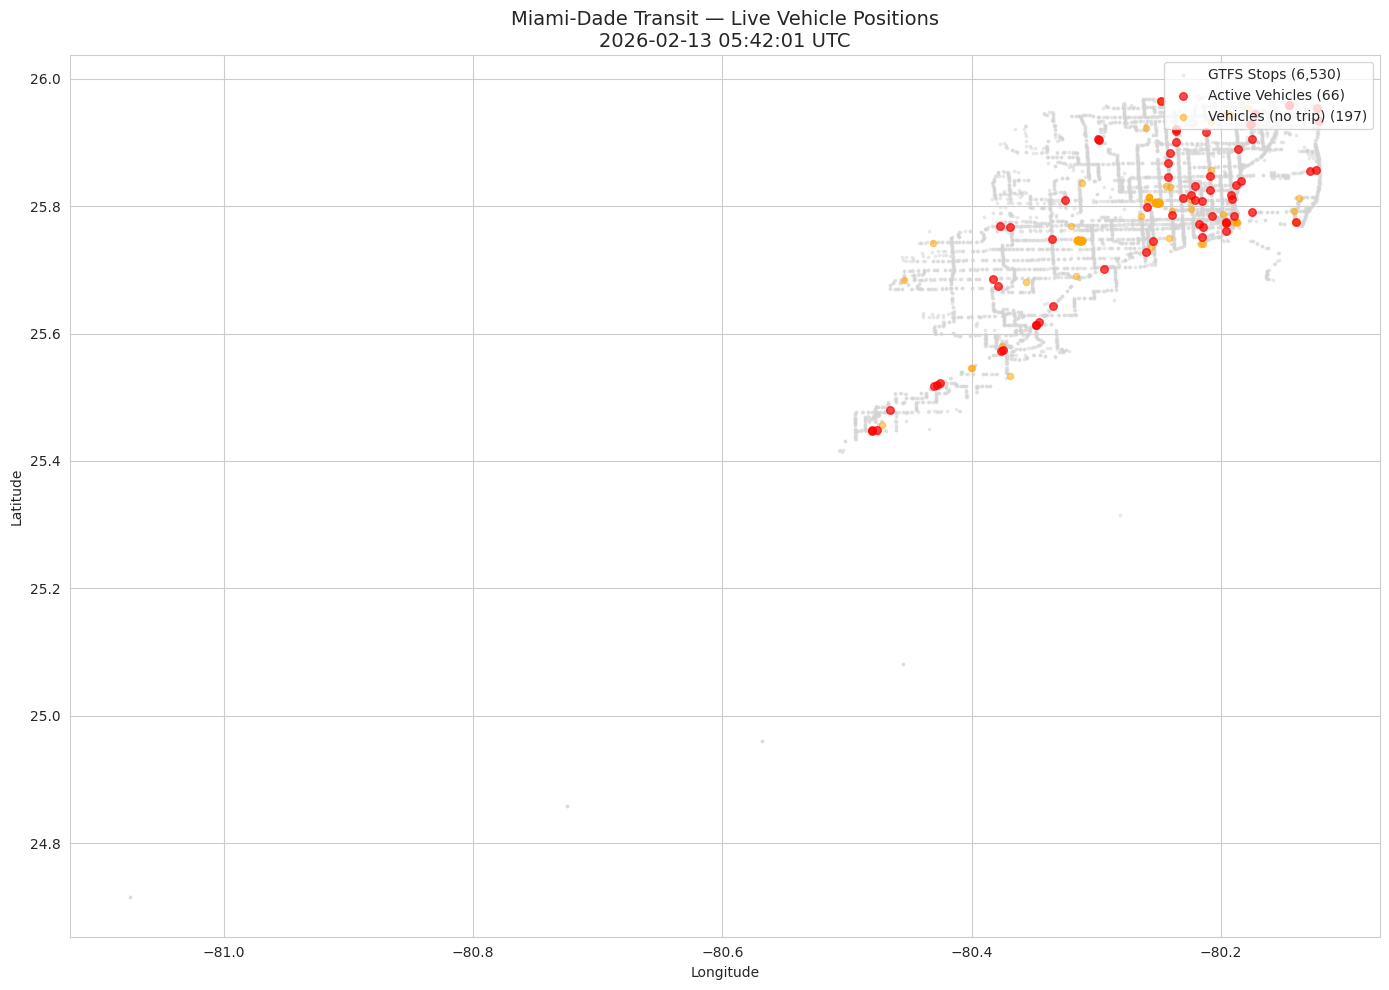

✓ Map shows 263 active vehicles against 6530 scheduled stops


In [26]:
# Visualize real-time vehicle positions vs scheduled stops
fig, ax = plt.subplots(figsize=(14, 10))

# Plot static stops (from GTFS)
stops = gtfs_data['stops']
ax.scatter(stops['stop_lon'], stops['stop_lat'], c='lightgray', s=3, alpha=0.4, label=f'GTFS Stops ({len(stops):,})')

# Plot live vehicle positions
has_route = df_vehicles['route_id'].notna()
ax.scatter(df_vehicles.loc[has_route, 'longitude'], df_vehicles.loc[has_route, 'latitude'],
           c='red', s=30, alpha=0.7, zorder=5, label=f'Active Vehicles ({has_route.sum()})')
ax.scatter(df_vehicles.loc[~has_route, 'longitude'], df_vehicles.loc[~has_route, 'latitude'],
           c='orange', s=20, alpha=0.5, zorder=4, label=f'Vehicles (no trip) ({(~has_route).sum()})')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Miami-Dade Transit — Live Vehicle Positions\n{snapshot_time}', fontsize=14)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()
print(f"✓ Map shows {len(df_vehicles)} active vehicles against {len(stops)} scheduled stops")

### 5B.5 Stop-Level Delay Extraction

In [27]:
# Extract detailed stop-level delay data from trip updates
stop_delay_records = []
for entity in trip_entities:
    tu = entity.get('tripUpdate', {})
    trip_info = tu.get('trip', {})
    for stu in tu.get('stopTimeUpdate', []):
        arrival = stu.get('arrival', {})
        departure = stu.get('departure', {})
        stop_delay_records.append({
            'trip_id': trip_info.get('tripId'),
            'route_id': trip_info.get('routeId'),
            'stop_id': stu.get('stopId'),
            'stop_sequence': stu.get('stopSequence'),
            'arrival_delay_sec': arrival.get('delay', None),
            'arrival_time': arrival.get('time'),
            'departure_delay_sec': departure.get('delay', None),
            'departure_time': departure.get('time'),
            'schedule_relationship': stu.get('scheduleRelationship', 'SCHEDULED'),
        })

df_stop_delays = pd.DataFrame(stop_delay_records)
print(f"Stop-Level Delay Records: {df_stop_delays.shape}")
print(f"\nDelay data availability:")
print(f"  Records with arrival_delay:   {df_stop_delays['arrival_delay_sec'].notna().sum():,}")
print(f"  Records with departure_delay: {df_stop_delays['departure_delay_sec'].notna().sum():,}")
print(f"  Records with arrival_time:    {df_stop_delays['arrival_time'].notna().sum():,}")

if df_stop_delays['arrival_delay_sec'].notna().sum() > 0:
    print(f"\nArrival Delay Distribution (seconds):")
    print(df_stop_delays['arrival_delay_sec'].describe().to_string())
    
    fig, ax = plt.subplots(figsize=(12, 5))
    delays = df_stop_delays['arrival_delay_sec'].dropna()
    delays_min = delays / 60  # convert to minutes
    ax.hist(delays_min, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
    ax.axvline(x=0, color='green', linestyle='--', label='On time')
    ax.axvline(x=delays_min.median(), color='red', linestyle='--', label=f'Median: {delays_min.median():.1f} min')
    ax.set_xlabel('Delay (minutes)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Arrival Delays — Miami-Dade Transit (Live Snapshot)')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  No delay values in this snapshot (delays may be reported as predicted times only)")
    print("   Use arrival_time timestamps to compute delays against scheduled times from GTFS static")

df_stop_delays.head(10)

Stop-Level Delay Records: (3704, 9)

Delay data availability:
  Records with arrival_delay:   0
  Records with departure_delay: 0
  Records with arrival_time:    3,663

⚠️  No delay values in this snapshot (delays may be reported as predicted times only)
   Use arrival_time timestamps to compute delays against scheduled times from GTFS static


,trip_id,route_id,stop_id,stop_sequence,arrival_delay_sec,arrival_time,departure_delay_sec,departure_time,schedule_relationship
0,6094763,30437,1378,79,None,1770961423,None,None,SCHEDULED
1,6094763,30437,1379,80,None,1770961444,None,None,SCHEDULED
2,6094763,30437,1380,81,None,1770961462,None,None,SCHEDULED
3,6094763,30437,1386,82,None,1770961527,None,None,SCHEDULED
4,6094763,30437,1387,83,None,1770961557,None,None,SCHEDULED
5,6094763,30437,34,84,None,1770961628,None,None,SCHEDULED
6,6088272,30408,8239,138,None,1770961335,None,None,SCHEDULED
7,6088272,30408,119,139,None,1770961383,None,None,SCHEDULED
8,6088276,30408,8691,141,None,1770961269,None,None,SCHEDULED
9,6088276,30408,5828,142,None,1770961326,None,None,SCHEDULED


### 5B.6 GTFS-Realtime Data Summary

**What It Is:** Live operational data for Miami-Dade Transit — real-time vehicle positions and predicted arrival/departure times at stops, served via the Swiftly GTFS-rt API.

**Two feeds:**
- **Trip Updates:** Predicted stop times for active trips — enables delay calculation, on-time performance, schedule adherence
- **Vehicle Positions:** GPS coordinates of every active vehicle — enables spatial analysis of actual service coverage vs. planned coverage

**Key for the Project:**
- **Equity measurement:** Compare *actual* service delivery across neighborhoods vs. *planned* service. Do underserved areas experience more delays?
- **Service reliability:** Calculate on-time performance by route, time of day, and geography
- **Links to GTFS Static:** `trip_id`, `route_id`, and `stop_id` fields directly join to the static GTFS tables — you can compare scheduled vs. actual arrival times
- **Temporal dimension:** Collecting snapshots over time builds a dataset of service reliability that static data alone can't capture

**Data Quality Notes:**
- Data is a real-time snapshot — varies by time of day and day of week
- For robust analysis, collect multiple snapshots across peak/off-peak hours and weekdays/weekends
- Rate limit: 180 requests per 15 minutes (~1 request every 5 seconds)
- Vehicle positions that lack `trip_id` are typically deadheading (not in revenue service)

## Section 6: Cross-Dataset Integration Strategy

### 6.1 Geographic Join Strategy

**The Core Challenge:** Our four datasets operate at different geographic levels and data types:

| Dataset | Geographic Level | Type | Join Key |
|---|---|---|---|
| Census ACS DP03 | State (need tract) | Tabular | Census Tract FIPS |
| GTFS Static | Point (lat/lon) | Tabular + spatial | Spatial join → Tract |
| Accessibility | Census Block (15-digit FIPS) | Geo + tabular | Block → Tract aggregation |
| GTFS-Realtime | Point (lat/lon) + trip/stop IDs | Temporal + spatial | `trip_id`/`stop_id` → GTFS Static → Tract |

**Common denominator: Census Tract** — all four datasets can be linked at this level.

**GTFS-RT integration path:** GTFS-Realtime → join via `trip_id`/`route_id`/`stop_id` to GTFS Static → spatial join stops to tracts → aggregate delay metrics per tract.

In [28]:
# Demonstrate geographic join strategy
try:
    # Extract Miami-Dade tracts from blocks
    blocks_df = gdf_blocks[['blockid']].copy()
    
    # Convert blockid to tract FIPS (first 11 digits)
    blocks_df['tract_fips'] = blocks_df['blockid'].astype(str).str[:11]
    
    # Identify Miami-Dade blocks
    miamiDade_blocks = blocks_df[blocks_df['blockid'].astype(str).str.startswith('12086')]
    
    # Get unique tracts
    miamiDade_tracts = miamiDade_blocks['tract_fips'].unique()
    
    print("Miami-Dade County Geographic Hierarchy:")
    print("=" * 70)
    print(f"Total blocks in dataset: {len(blocks_df):,}")
    print(f"Miami-Dade blocks: {len(miamiDade_blocks):,} ({len(miamiDade_blocks)/len(blocks_df)*100:.1f}%)")
    print(f"Miami-Dade unique tracts: {len(miamiDade_tracts)}")
    
    print(f"\nSample Miami-Dade tract FIPSes:")
    for i, tract in enumerate(sorted(miamiDade_tracts)[:10]):
        print(f"  {tract}")
    if len(miamiDade_tracts) > 10:
        print(f"  ... and {len(miamiDade_tracts) - 10} more tracts")
    
    print(f"\n✓ Block → Tract aggregation path confirmed")
    
except Exception as e:
    print(f"Note: {e}")
    print("Geographic hierarchy structure explained via documentation")


Miami-Dade County Geographic Hierarchy:
Total blocks in dataset: 36,507
Miami-Dade blocks: 36,471 (99.9%)
Miami-Dade unique tracts: 516

Sample Miami-Dade tract FIPSes:
  12086000107
  12086000109
  12086000113
  12086000115
  12086000118
  12086000119
  12086000120
  12086000121
  12086000122
  12086000123
  ... and 506 more tracts

✓ Block → Tract aggregation path confirmed


### 6.2 Recommended Integration Approach

**Step-by-Step Data Integration Pipeline:**

1. **Re-query Census ACS** at tract level for Miami-Dade County (FIPS 12086)
2. **Aggregate Accessibility data** from block → tract level (avg/sum jobs accessible)
3. **Spatial join GTFS stops** to census tracts using geopandas
4. **Compute per-tract transit features** from GTFS Static (stop count, route count, avg frequency)
5. **Collect GTFS-RT snapshots** over multiple days/times → compute per-stop delay metrics
6. **Aggregate RT delay metrics** to tract level via stop-to-tract mapping from step 3
7. **Join all four** at tract level → unified analytical table

**Final unified table (one row per census tract):**
- Demographics & economics (Census ACS)
- Job accessibility by mode & travel time (Accessibility Evaluation)
- Transit service supply metrics (GTFS Static)
- Actual service performance & reliability (GTFS-Realtime)

### 6.3 Data Dictionary Preview

In [29]:
# Create a summary of all four datasets
data_dictionary = pd.DataFrame({
    'Dataset': ['US Census ACS (DP03)', 'GTFS Static', 'National Accessibility', 'GTFS-Realtime (Swiftly)'],
    'Source': ['Census Bureau API', 'Miami-Dade Transit', 'EPA/USDOT via ArcGIS', 'Swiftly API'],
    'Geographic Level': ['State (need tract)', 'Point (stop lat/lon)', 'Census Block', 'Point (vehicle GPS) + stop IDs'],
    'Rows': ['1 (state-level)', f"{len(gtfs_data['stops']):,} stops / {len(gtfs_data['trips']):,} trips",
             '36,507 blocks × 13 time layers', f"{len(trip_entities)} trips / {len(veh_entities)} vehicles (snapshot)"],
    'Key Variables': ['Employment, commuting mode, income, poverty',
                      'Routes, stops, schedules, shapes',
                      'Jobs accessible by mode & travel time',
                      'Live positions, delays, schedule adherence'],
    'Data Year': ['2023', 'Current feed', '2021 (LEHD 2018-2019)', 'Real-time'],
    'Format': ['JSON (API)', 'CSV (ZIP)', 'GeoPackage (.gpkg)', 'JSON/Protobuf (API)'],
    'Join Strategy': ['Re-query at tract level → tract FIPS',
                      'Spatial join stops → tracts',
                      'Block FIPS → aggregate to tract',
                      'trip_id/stop_id → GTFS Static → tract']
})

print("=" * 80)
print("DATA DICTIONARY — All Four Datasets")
print("=" * 80)
data_dictionary.set_index('Dataset')

DATA DICTIONARY — All Four Datasets


,Source,Geographic Level,Rows,Key Variables,Data Year,Format,Join Strategy
Dataset,,,,,,,
US Census ACS (DP03),Census Bureau API,State (need tract),1 (state-level),"Employment, commuting mode, income, poverty",2023,JSON (API),Re-query at tract level → tract FIPS
GTFS Static,Miami-Dade Transit,Point (stop lat/lon),"6,530 stops / 24,529 trips","Routes, stops, schedules, shapes",Current feed,CSV (ZIP),Spatial join stops → tracts
National Accessibility,EPA/USDOT via ArcGIS,Census Block,"36,507 blocks × 13 time layers",Jobs accessible by mode & travel time,2021 (LEHD 2018-2019),GeoPackage (.gpkg),Block FIPS → aggregate to tract
GTFS-Realtime (Swiftly),Swiftly API,Point (vehicle GPS) + stop IDs,101 trips / 263 vehicles (snapshot),"Live positions, delays, schedule adherence",Real-time,JSON/Protobuf (API),trip_id/stop_id → GTFS Static → tract


### 6.4 Team Notes

**Lina's Google Drive Path:** The `BASE_PATH = Path('/content/drive/MyDrive/YOUR_FOLDER_NAME/')` configuration found by teammate Lina is a **Google Colab environment variable** — it specifies where data files are stored when running notebooks in Colab. For local/GitHub work, data is stored in the repo's `data/` folder structure instead.

**Swiftly API Access:** Obtained through Miami-Dade County's open data program. The API key and license were provided by Swiftly, Inc. after agreeing to their API terms. Key details:
- API Key: provided via email to the team
- Rate Limit: 180 requests per 15 minutes
- Endpoints: Trip Updates + Vehicle Positions
- Terms: "AS IS" basis, access may be revoked at any time

## Section 7: Key Findings & Next Steps

### Data Fitness Assessment (for January 30 Decision Gate)

| Dataset | Status | Notes |
|---|---|---|
| GTFS Static | ✅ Ready | 129 routes, 6,530 stops — excellent Miami-Dade coverage |
| GTFS-Realtime | ✅ Ready | Live trip updates & vehicle positions via Swiftly API |
| Accessibility | ✅ Ready | 36,507 blocks × multiple modes/time windows — ideal for equity analysis |
| Census ACS | ⚠️ Needs Work | Currently state-level only — must re-query at tract level for Miami-Dade |

**Geographic Alignment:** Census tract is the recommended common join level across all 4 datasets. The GTFS Static ↔ GTFS-RT link via `trip_id`/`stop_id` is a strong bridge.

### Immediate Next Steps (Sprint 1b)
1. **Re-query Census ACS** at tract level for Miami-Dade County (FIPS 12086)
2. **Build GTFS-RT collection pipeline** — scheduled snapshots across peak/off-peak, weekday/weekend
3. **Build geographic join pipeline** — block→tract aggregation, stop→tract spatial join
4. **Create merged analytical dataset** at census tract level
5. **Build data dictionary** with all variable definitions
6. **Begin EDA visualizations** — maps, distributions, correlations

### Hypotheses to Explore
- Areas with low transit accessibility scores also have higher poverty rates and lower car ownership
- There are significant accessibility gaps between auto and transit modes in low-income tracts
- Some neighborhoods have high population density but poor transit frequency (underserved areas)
- **NEW (from GTFS-RT):** Service reliability (delays) may be worse in equity-priority neighborhoods — actual performance doesn't match planned schedules equally across the county

## Section 8: Tract-Level Merged Dataset

> **This section queries the Census API at tract level for Miami-Dade County, performs spatial joins, aggregates all 4 datasets to the census tract level, and produces a final GeoPackage with polygons.**

### 8.1 Census ACS 5-Year at Tract Level

ACS 1-Year data is only available for geographies with 65,000+ population. For tract-level data we use the **ACS 5-Year** estimates.

In [30]:
# Query Census ACS DP03 at TRACT level for Miami-Dade County (FIPS 12086)
import requests

variables = [
    'DP03_0001E','DP03_0002E','DP03_0004E','DP03_0005E',
    'DP03_0018E','DP03_0019E','DP03_0020E','DP03_0021E','DP03_0022E','DP03_0023E','DP03_0024E','DP03_0025E',
    'DP03_0062E','DP03_0063E','DP03_0088E','DP03_0119E',
    'DP03_0128E','DP03_0129E',
    'DP03_0033E','DP03_0034E','DP03_0035E','DP03_0036E','DP03_0037E','DP03_0038E',
    'DP03_0027E','DP03_0028E',
]
url = f"https://api.census.gov/data/2023/acs/acs5/profile?get={','.join(variables)},NAME&for=tract:*&in=state:12&in=county:086"
response = requests.get(url, timeout=30)
census_tract_raw = response.json()
df_census_tract = pd.DataFrame(census_tract_raw[1:], columns=census_tract_raw[0])
df_census_tract['tract_fips'] = '12086' + df_census_tract['tract'].str.zfill(6)

rename_map = {
    'DP03_0001E':'pop_16plus','DP03_0002E':'in_labor_force','DP03_0004E':'employed','DP03_0005E':'unemployed',
    'DP03_0018E':'workers_16plus','DP03_0019E':'commute_drove_alone','DP03_0020E':'commute_carpooled',
    'DP03_0021E':'commute_public_transit','DP03_0022E':'commute_walked','DP03_0023E':'commute_other',
    'DP03_0024E':'commute_work_from_home','DP03_0025E':'mean_commute_time_min',
    'DP03_0062E':'median_household_income','DP03_0063E':'mean_household_income',
    'DP03_0088E':'per_capita_income','DP03_0119E':'poverty_rate_pct',
    'DP03_0128E':'with_health_insurance','DP03_0129E':'without_health_insurance',
    'DP03_0033E':'industry_agriculture','DP03_0034E':'industry_construction',
    'DP03_0035E':'industry_manufacturing','DP03_0036E':'industry_wholesale',
    'DP03_0037E':'industry_retail','DP03_0038E':'industry_transport_warehouse',
    'DP03_0027E':'occupation_management','DP03_0028E':'occupation_service',
}
df_census_tract = df_census_tract.rename(columns=rename_map)
df_census_tract = df_census_tract[['tract_fips','NAME'] + list(rename_map.values())]
for col in rename_map.values(): df_census_tract[col] = pd.to_numeric(df_census_tract[col], errors='coerce')
print(f"Census tracts for Miami-Dade: {len(df_census_tract)}")
df_census_tract.head()

Census tracts for Miami-Dade: 707


,tract_fips,NAME,pop_16plus,in_labor_force,employed,unemployed,workers_16plus,commute_drove_alone,commute_carpooled,commute_public_transit,commute_walked,commute_other,commute_work_from_home,mean_commute_time_min,median_household_income,mean_household_income,per_capita_income,poverty_rate_pct,with_health_insurance,without_health_insurance,industry_agriculture,industry_construction,industry_manufacturing,industry_wholesale,industry_retail,industry_transport_warehouse,occupation_management,occupation_service
0,12086000107,Census Tract 1.07; Miami-Dade County; Florida,2474,1545,1487,58,1476,909,115,49,0,23,380,26.7,53281,114816,54784,-888888888,-888888888,-888888888,0,42,54,12,204,34,631,391
1,12086000109,Census Tract 1.09; Miami-Dade County; Florida,3053,2026,2000,26,1979,1293,212,178,53,25,218,28.0,59577,76117,31513,-888888888,-888888888,-888888888,0,169,109,62,132,261,680,442
2,12086000115,Census Tract 1.15; Miami-Dade County; Florida,1538,889,812,77,812,519,96,8,5,69,115,29.1,104427,220216,94396,-888888888,-888888888,-888888888,3,62,45,40,53,107,365,145
3,12086000118,Census Tract 1.18; Miami-Dade County; Florida,915,415,396,19,387,183,24,24,16,7,133,33.6,103309,205299,89072,-888888888,-888888888,-888888888,0,0,20,41,86,0,236,39
4,12086000120,Census Tract 1.20; Miami-Dade County; Florida,3499,2192,2005,187,1972,1179,71,15,19,126,562,31.3,73667,122848,59310,-888888888,-888888888,-888888888,0,109,71,167,132,203,1100,107


### 8.2 Build Tract Polygons & Spatial Join GTFS Stops

In [31]:
# Build tract polygons from accessibility blocks
import pyogrio
accessibility_path = '/sessions/adoring-optimistic-cori/data/accessibility/out/'
transit_gpkg = accessibility_path + '12197701_tr_2021_0700-0859-avg.gpkg'
auto_gpkg = accessibility_path + '12197701_au_2021_08.gpkg'
bike_gpkg = accessibility_path + '12197701_bi_2021_1200_lts2.gpkg'

gdf_blocks_all = pyogrio.read_dataframe(transit_gpkg, layer='blocks')
gdf_blocks_all['tract_fips'] = gdf_blocks_all['blockid'].astype(str).str[:11]
gdf_tracts = gdf_blocks_all.dissolve(by='tract_fips').reset_index()[['tract_fips','geometry']]
block_tract_map = gdf_blocks_all[['blockid','tract_fips']].copy()
block_tract_map['id'] = block_tract_map['blockid']
print(f"Tract polygons: {len(gdf_tracts)}")

# Spatial join stops → tracts
gdf_stops_geo = gpd.GeoDataFrame(gtfs_data['stops'],
    geometry=gpd.points_from_xy(gtfs_data['stops'].stop_lon, gtfs_data['stops'].stop_lat), crs='EPSG:4326')
gdf_stops_tract = gpd.sjoin(gdf_stops_geo, gdf_tracts, how='left', predicate='within')
print(f"Stops matched: {gdf_stops_tract['tract_fips'].notna().sum()}/{len(gtfs_data['stops'])} ({gdf_stops_tract['tract_fips'].notna().mean()*100:.1f}%)")

# Aggregate GTFS per tract
tps = gtfs_data['stop_times'].groupby('stop_id')['trip_id'].nunique().reset_index(name='n_trips')
sr = gtfs_data['stop_times'].merge(gtfs_data['trips'][['trip_id','route_id']], on='trip_id')
rps = sr.groupby('stop_id')['route_id'].nunique().reset_index(name='n_routes')
gdf_stops_tract = gdf_stops_tract.merge(tps, on='stop_id', how='left').merge(rps, on='stop_id', how='left')

gtfs_by_tract = gdf_stops_tract.groupby('tract_fips').agg(
    n_stops=('stop_id','count'), n_trips_total=('n_trips','sum'),
    n_routes_served=('n_routes','max'), avg_trips_per_stop=('n_trips','mean'),
    wheelchair_accessible_stops=('wheelchair_boarding', lambda x: (x==1).sum())).reset_index()

srt = sr.merge(gtfs_data['routes'][['route_id','route_type']], on='route_id')
srt = srt.merge(gdf_stops_tract[['stop_id','tract_fips']].drop_duplicates(), on='stop_id')
gtfs_by_tract = gtfs_by_tract.merge(
    srt.groupby('tract_fips')['route_type'].apply(lambda x: int((x.isin([0,1,2])).any())).reset_index(name='has_rail_access'),
    on='tract_fips', how='left')
print(f"GTFS aggregated: {len(gtfs_by_tract)} tracts with transit")

Tract polygons: 522
Stops matched: 6490/6530 (99.4%)


GTFS aggregated: 496 tracts with transit


### 8.3 Aggregate Accessibility to Tract Level

In [32]:
# Aggregate accessibility at 15/30/45/60 min for transit + auto
acc_merged = None
for minutes in [15, 30, 45, 60]:
    tr = pyogrio.read_dataframe(transit_gpkg, layer=f'tr_{minutes}_minutes')
    tr = tr.merge(block_tract_map[['id','tract_fips']], on='id', how='left')
    au = pyogrio.read_dataframe(auto_gpkg, layer=f'au_08_{minutes}_minutes')
    au = au.merge(block_tract_map[['id','tract_fips']], on='id', how='left')
    ta = tr.groupby('tract_fips').agg(**{f'transit_jobs_{minutes}min':('w_c000_19','mean'),
        f'transit_workers_{minutes}min':('r_c000_19','mean')}).reset_index()
    aa = au.groupby('tract_fips').agg(**{f'auto_jobs_{minutes}min':('w_c000_19','mean')}).reset_index()
    mm = ta.merge(aa, on='tract_fips', how='outer')
    mm[f'transit_auto_ratio_{minutes}min'] = (mm[f'transit_jobs_{minutes}min']/mm[f'auto_jobs_{minutes}min'].replace(0,np.nan)).round(4)
    acc_merged = mm if acc_merged is None else acc_merged.merge(mm, on='tract_fips', how='outer')
    print(f"  {minutes}-min: {len(mm)} tracts")

# Bicycle (LTS 2, 30 min)
bi = pyogrio.read_dataframe(bike_gpkg, layer='bi_30_minutes').merge(block_tract_map[['id','tract_fips']], on='id', how='left')
acc_merged = acc_merged.merge(bi.groupby('tract_fips').agg(bike_lts2_jobs_30min=('w_c000_19','mean')).reset_index(), on='tract_fips', how='left')
print(f"\nAccessibility: {len(acc_merged)} tracts, {len(acc_merged.columns)} columns")

  15-min: 522 tracts


  30-min: 522 tracts


  45-min: 522 tracts


  60-min: 522 tracts



Accessibility: 522 tracts, 18 columns


### 8.4 Final Merge — All 4 Datasets

In [33]:
# GTFS-RT to tracts
dv = pd.DataFrame([{'vid':e.get('vehicle',{}).get('vehicle',{}).get('id'),
    'lat':e.get('vehicle',{}).get('position',{}).get('latitude'),
    'lon':e.get('vehicle',{}).get('position',{}).get('longitude')} for e in veh_entities]).dropna(subset=['lat','lon'])
gdf_veh = gpd.sjoin(gpd.GeoDataFrame(dv, geometry=gpd.points_from_xy(dv.lon,dv.lat), crs='EPSG:4326'),
    gdf_tracts, how='left', predicate='within')
rt_by_tract = gdf_veh.groupby('tract_fips').agg(rt_active_vehicles=('vid','nunique')).reset_index()

# MERGE ALL
merged = df_census_tract.merge(gtfs_by_tract, on='tract_fips', how='left')
merged = merged.merge(acc_merged, on='tract_fips', how='left')
merged = merged.merge(rt_by_tract, on='tract_fips', how='left')

# Derived columns
merged['pct_public_transit'] = (merged['commute_public_transit']/merged['workers_16plus'].replace(0,np.nan)*100).round(2)
merged['pct_drove_alone'] = (merged['commute_drove_alone']/merged['workers_16plus'].replace(0,np.nan)*100).round(2)
merged['unemployment_rate'] = (merged['unemployed']/merged['in_labor_force'].replace(0,np.nan)*100).round(2)
merged['transit_desert'] = ((merged['n_stops'].fillna(0)==0)&(merged['poverty_rate_pct']>20)).astype(int)
for col in ['n_stops','n_trips_total','has_rail_access','rt_active_vehicles','wheelchair_accessible_stops','transit_desert']:
    if col in merged.columns: merged[col] = merged[col].fillna(0).astype(int)

# Attach geometry
gdf_final = gdf_tracts.merge(merged, on='tract_fips', how='right')
gdf_final = gpd.GeoDataFrame(gdf_final, geometry='geometry', crs='EPSG:4326')

print(f"FINAL MERGED DATASET: {gdf_final.shape[0]} tracts × {gdf_final.shape[1]} columns")
print(f"With geometry: {gdf_final.geometry.notna().sum()}")
print(f"\nCoverage:")
print(f"  Census:        {merged['pop_16plus'].notna().sum()}/{len(merged)}")
print(f"  GTFS:          {(merged['n_stops']>0).sum()}/{len(merged)} with transit")
print(f"  Accessibility: {merged['transit_jobs_30min'].notna().sum()}/{len(merged)}")
print(f"  GTFS-RT:       {(merged['rt_active_vehicles']>0).sum()}/{len(merged)} (snapshot)")
print(f"  Transit deserts: {merged['transit_desert'].sum()}")

FINAL MERGED DATASET: 707 tracts × 57 columns
With geometry: 354

Coverage:
  Census:        707/707
  GTFS:          335/707 with transit
  Accessibility: 354/707
  GTFS-RT:       52/707 (snapshot)
  Transit deserts: 0


### 8.5 Choropleth Maps

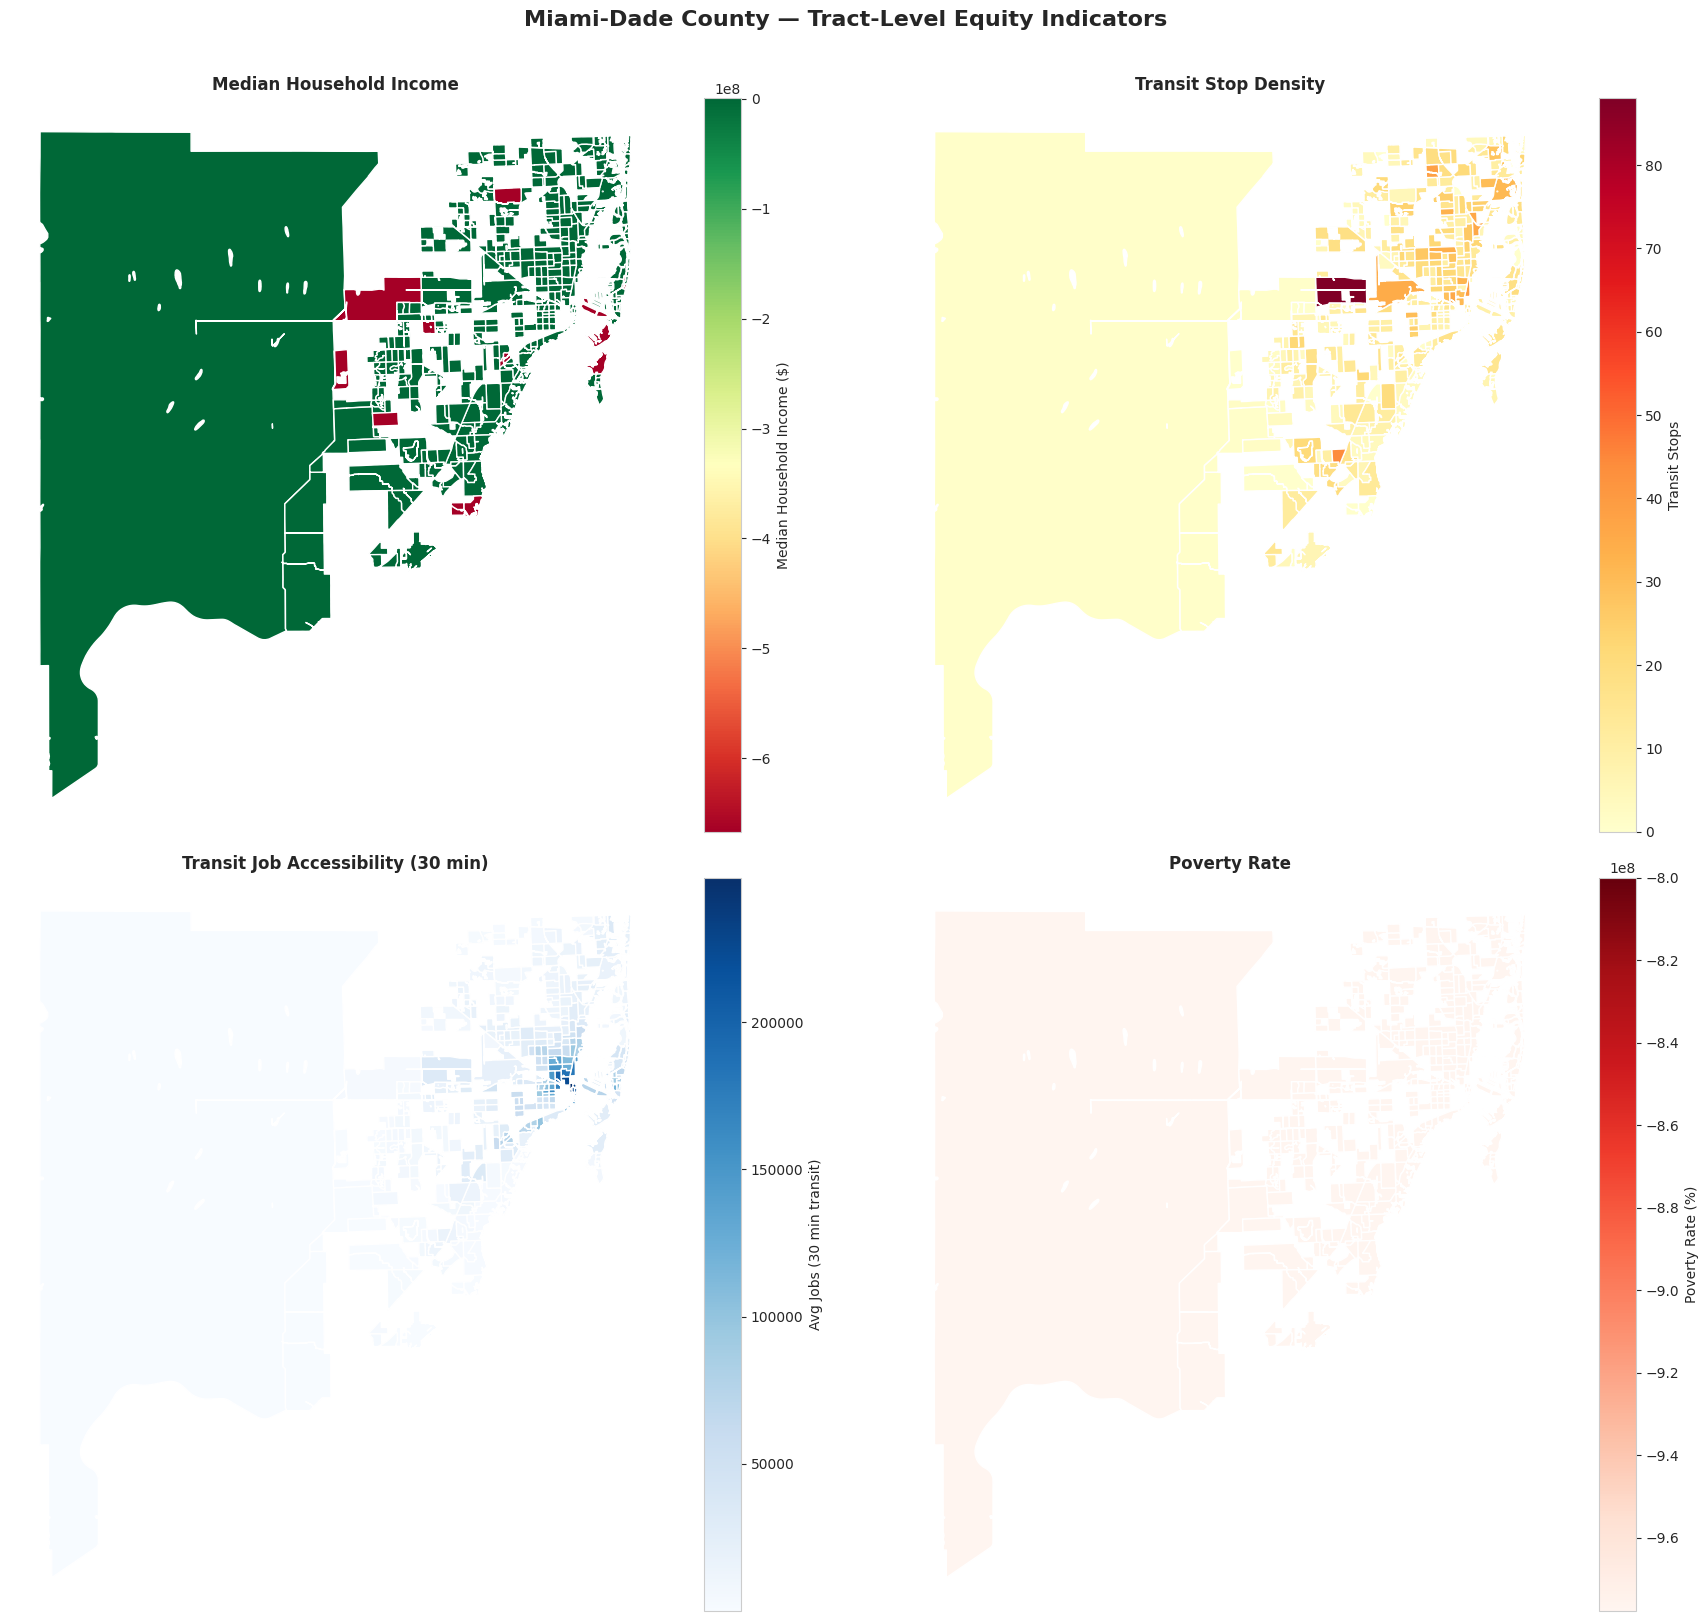

In [34]:
# Choropleth maps
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
gdf_plot = gdf_final[gdf_final.geometry.notna()].copy()

gdf_plot.plot(column='median_household_income', cmap='RdYlGn', legend=True, ax=axes[0,0],
    legend_kwds={'label':'Median Household Income ($)'}, missing_kwds={'color':'lightgrey'})
axes[0,0].set_title('Median Household Income', fontweight='bold'); axes[0,0].set_axis_off()

gdf_plot.plot(column='n_stops', cmap='YlOrRd', legend=True, ax=axes[0,1],
    legend_kwds={'label':'Transit Stops'}, missing_kwds={'color':'lightgrey'})
axes[0,1].set_title('Transit Stop Density', fontweight='bold'); axes[0,1].set_axis_off()

gdf_plot.plot(column='transit_jobs_30min', cmap='Blues', legend=True, ax=axes[1,0],
    legend_kwds={'label':'Avg Jobs (30 min transit)'}, missing_kwds={'color':'lightgrey'})
axes[1,0].set_title('Transit Job Accessibility (30 min)', fontweight='bold'); axes[1,0].set_axis_off()

gdf_plot.plot(column='poverty_rate_pct', cmap='Reds', legend=True, ax=axes[1,1],
    legend_kwds={'label':'Poverty Rate (%)'}, missing_kwds={'color':'lightgrey'})
axes[1,1].set_title('Poverty Rate', fontweight='bold'); axes[1,1].set_axis_off()

plt.suptitle('Miami-Dade County — Tract-Level Equity Indicators', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout(); plt.show()

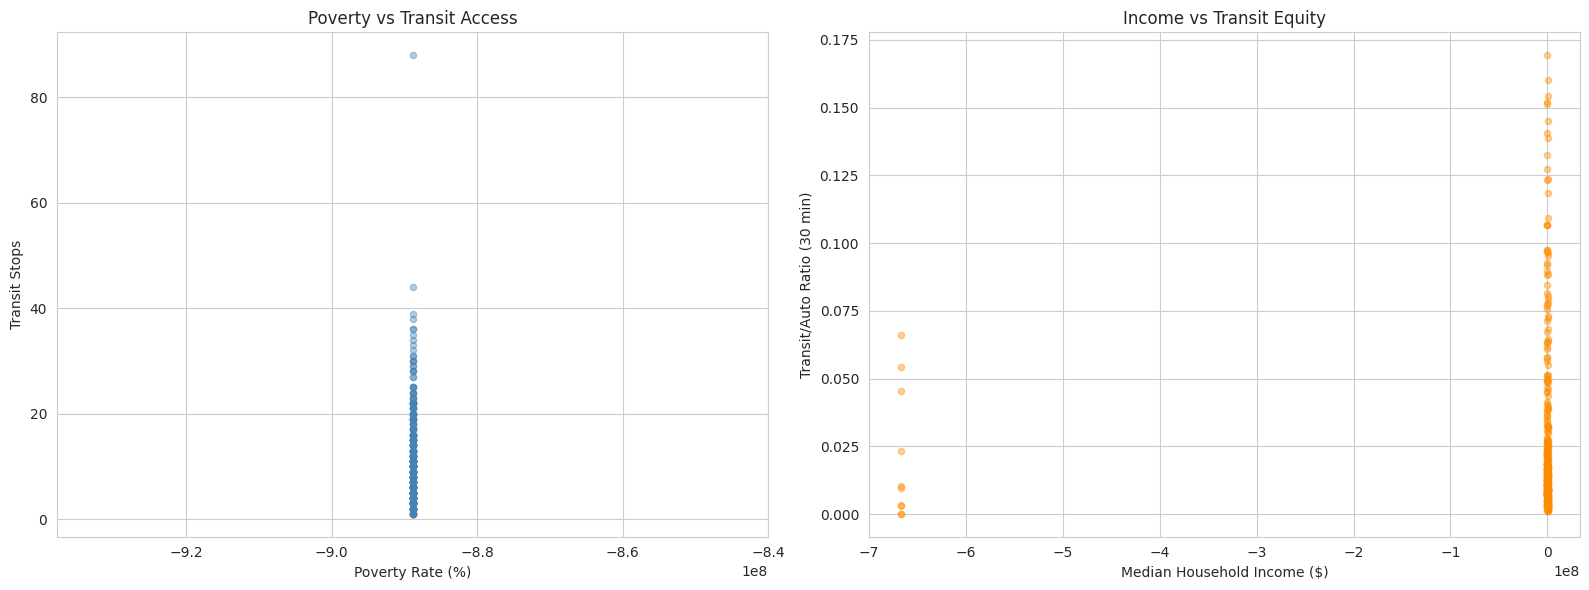

Correlation: Poverty ↔ Stops = nan
Correlation: Income ↔ Transit/Auto Ratio = 0.027


In [35]:
# Equity scatter: poverty vs transit
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
valid = merged[merged['poverty_rate_pct'].notna() & (merged['n_stops']>0)]
axes[0].scatter(valid['poverty_rate_pct'], valid['n_stops'], alpha=0.4, s=20, c='steelblue')
axes[0].set_xlabel('Poverty Rate (%)'); axes[0].set_ylabel('Transit Stops')
axes[0].set_title('Poverty vs Transit Access')

valid2 = merged[merged['median_household_income'].notna() & merged['transit_auto_ratio_30min'].notna()]
axes[1].scatter(valid2['median_household_income'], valid2['transit_auto_ratio_30min'], alpha=0.4, s=20, c='darkorange')
axes[1].set_xlabel('Median Household Income ($)'); axes[1].set_ylabel('Transit/Auto Ratio (30 min)')
axes[1].set_title('Income vs Transit Equity')
plt.tight_layout(); plt.show()

print(f"Correlation: Poverty ↔ Stops = {merged['poverty_rate_pct'].corr(merged['n_stops']):.3f}")
print(f"Correlation: Income ↔ Transit/Auto Ratio = {merged['median_household_income'].corr(merged['transit_auto_ratio_30min']):.3f}")

### 8.6 Export

In [36]:
# Save GeoPackage (3 layers) + CSV
import shutil
work_gpkg = '/sessions/adoring-optimistic-cori/merged_output_nb.gpkg'
if os.path.exists(work_gpkg): os.remove(work_gpkg)
gdf_final.to_file(work_gpkg, driver='GPKG', layer='tracts')
gdf_stops_tract[['stop_id','stop_name','stop_lat','stop_lon','wheelchair_boarding','tract_fips','n_trips','n_routes','geometry']].to_file(work_gpkg, driver='GPKG', layer='stops')
gdf_blocks_all[['blockid','tract_fips','geometry']].to_file(work_gpkg, driver='GPKG', layer='blocks')
csv_path = '/sessions/adoring-optimistic-cori/MiamiDade_Merged.csv'
gdf_final.drop(columns='geometry').to_csv(csv_path, index=False)

for name, geom in pyogrio.list_layers(work_gpkg): print(f"  '{name}' ({geom})")
print(f"\nGeoPackage: {os.path.getsize(work_gpkg)/1024/1024:.1f} MB")
print(f"CSV: {os.path.getsize(csv_path)/1024:.0f} KB")
print(f"Final: {gdf_final.shape[0]} tracts × {gdf_final.shape[1]} columns")

  'tracts' (MultiPolygon)
  'stops' (Point)
  'blocks' (MultiPolygon)

GeoPackage: 17.4 MB
CSV: 247 KB
Final: 707 tracts × 57 columns
